# Installs and Imports

In [ ]:

import os
import sys
import time
from datetime import datetime
import pickle
import json

import numpy as np
import matplotlib.cm as cm
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.stats import sem
from tqdm import tqdm
import pandas as pd
from scipy import stats


from tensorflow.keras.datasets import mnist, fashion_mnist
import tensorflow as tf
import cv2
from skimage.metrics import structural_similarity as ssi
import pickle

# D-Wave
from dwave.samplers import SimulatedAnnealingSampler
import dimod
from dimod import CQM, Binary, Integer, quicksum, cqm_to_bqm, BQM
from dwave.system import DWaveSampler, LeapHybridSampler, LeapHybridCQMSampler, LeapHybridNLSampler
from dwave.system.composites import EmbeddingComposite

# Gurobi Solver
import gurobipy as gp
from gurobipy import GRB

# Import environment variables
import dotenv
dotenv.load_dotenv()
solver_token = os.getenv('SOLVER_TOKEN')

# Import utilities
from utils.discrete import *

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


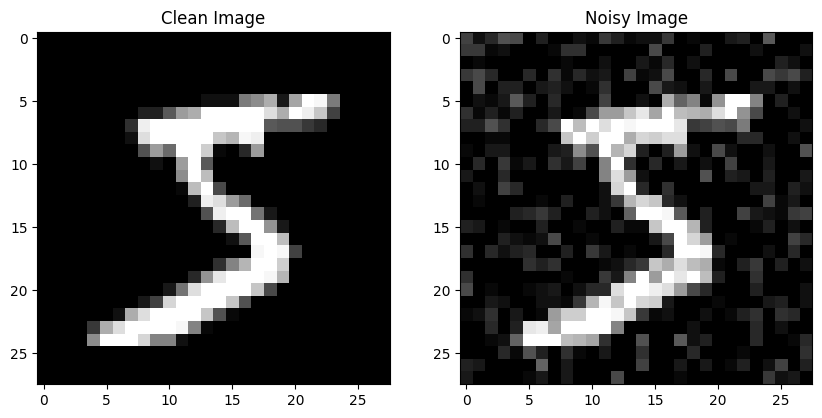

In [ ]:
# Prepare MNIST Data 
np.random.seed(0)

# Load and preprocess the MNIST dataset

# (x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
(x_train, y_train), (x_test, y_test) = mnist.load_data()
# print(f'Original shape: {x_train.shape}')
image_shape = (28,28)
x_train = np.array(tf.image.resize(x_train[..., tf.newaxis], image_shape, method=tf.image.ResizeMethod.BILINEAR))
x_test = np.array(tf.image.resize(x_test[..., tf.newaxis], image_shape, method=tf.image.ResizeMethod.BILINEAR))
x_train = x_train.reshape((len(x_train), 28, 28))
x_test = x_test.reshape((len(x_test), 28, 28))
# print(f'Downsized shape: {x_train.shape}')

# Scale between [0,1] and set dtype
x_train = x_train / 255
x_test  = x_test  / 255

# Add Gaussian noise to the images
noise_factor = 0.15 # @param
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape)
x_test_noisy  = x_test  + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape)

# Clip the pixel values to the valid range [0, 1]
x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy  = np.clip(x_test_noisy,  0., 1.)

# # Reshape data for the model
# x_train_noisy = np.reshape(x_train_noisy, (len(x_train_noisy), 12, 12, 1))
# x_test_noisy = np.reshape(x_test_noisy, (len(x_test_noisy), 12, 12, 1))

# # Rescale to [0, 255]
# x_train = x_train * 255
# x_test  = x_test  * 255

# # # Set dtype
# x_train = x_train.astype('float32')
# x_test  = x_test.astype('float32')
# x_train_noisy = x_train_noisy.astype('float32')
# x_test_noisy  = x_test_noisy.astype('float32')

# Binarize the images


precision = 2**5 # @param

precision -= 1
x_train = np.round(x_train * precision).astype(np.uint8)
x_test = np.round(x_test * precision).astype(np.uint8)
x_train_noisy = np.round(x_train_noisy * precision).astype(np.uint8)
x_test_noisy = np.round(x_test_noisy * precision).astype(np.uint8)



if True:
  fig, axes = plt.subplots(1, 2, figsize=(10, 5))
  axes[0].imshow(x_train[0], cmap='gray')
  axes[0].set_title('Clean Image')
  axes[1].imshow(x_train_noisy[0], cmap='gray')
  axes[1].set_title('Noisy Image')
  plt.show()


# Simple Example

[[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0.]
 [0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 1. 0. 1. 1. 0.]
 [0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 1. 1. 0. 0. 0. 1. 1. 0. 0. 0. 1.]
 [0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0.]
 [0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]


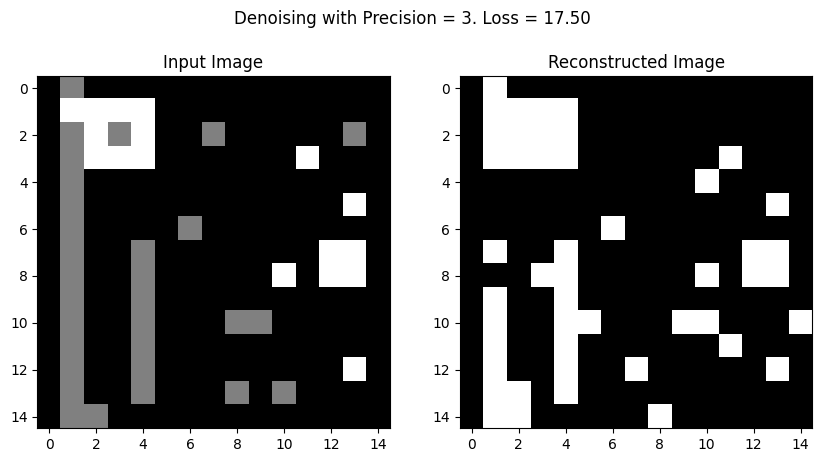

In [ ]:
# X_noisy = np.array([
#     [1, 1, 1], # 3x3
#     [1, 3, 1],
#     [1, 1, 1]
# ])

# X_noisy = np.array([[0, 1, 0, 0, 0, 0], # 6x6
#                     [0, 2, 2, 2, 2, 0],
#                     [0, 1, 2, 1, 2, 0],
#                     [0, 1, 2, 2, 2, 0],
#                     [0, 1, 0, 0, 0, 0],
#                     [0, 1, 1, 0, 0, 0]])

# X_noisy = np.array([[0, 1, 0, 0, 0, 0, 0, 0, 0],  # 9x9
#                     [0, 2, 2, 2, 2, 0, 0, 0, 0],
#                     [0, 1, 2, 1, 2, 0, 0, 1, 0],
#                     [0, 1, 2, 2, 2, 0, 0, 0, 0],
#                     [0, 1, 0, 0, 0, 0, 0, 0, 0],
#                     [0, 1, 0, 0, 0, 0, 0, 0, 0],
#                     [0, 1, 0, 0, 0, 0, 1, 0, 0],
#                     [0, 1, 0, 0, 1, 0, 0, 0, 0],
#                     [0, 1, 1, 0, 0, 0, 0, 0, 0]])


X_noisy = np.array([[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0 ],  # 15x15
                    [0, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0 ],
                    [0, 1, 2, 1, 2, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0 ],
                    [0, 1, 2, 2, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0 ],
                    [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0 ],
                    [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0 ],
                    [0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0 ],
                    [0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0 ],
                    [0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 2, 0, 2, 2, 0 ],
                    [0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0 ],
                    [0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0 ],
                    [0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0 ],
                    [0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0 ],
                    [0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0 ],
                    [0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0 ]])


precision = np.max(X_noisy)


solution = run_nl(X_noisy, l=0.8, time_limit=10)
print(solution)


fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(X_noisy, cmap='gray')
axes[0].set_title('Input Image')
cax2 = axes[1].imshow(solution, cmap='gray')
axes[1].set_title('Reconstructed Image')
# plt.colorbar(cax2, ax=axes[2])
plt.suptitle(f'Denoising with Precision = {precision+1}. Loss = {get_l1_loss(X_noisy, solution):.2f}')
plt.show()


### NL Sampler

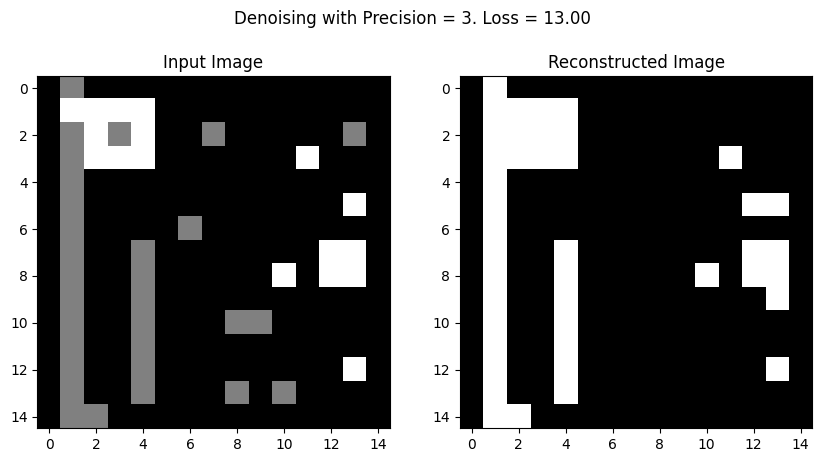

In [ ]:

# Alt method to use NL Solver from Ken, D-Wave

l = 0.82

n, m = X_noisy.shape

model = Model()

input = model.constant(X_noisy)

X_recon = model.integer(X_noisy.shape, lower_bound=0, upper_bound=precision)

c_2 = model.constant(2)
n1 = model.constant(-1)
zero = model.constant(0)

neighborhood_distance_const = model.constant(1-l)
retention_const = model.constant(l)

objective = retention_const * ((X_recon - input)**2).sum()    # Key change
# objective = retention_const * (abs(X_recon - input).sum())

for i in range(n):
    for j in range(m):
        for neighbor in get_neighbor(i, j, n, m, order=1):
            objective += neighborhood_distance_const * add(
                            X_recon[(i, j)]* X_recon[(i, j)],
                            X_recon[neighbor]*X_recon[neighbor],
                            n1 * c_2 * X_recon[neighbor] * X_recon[(i, j)]
                            ) # Neighborhood Distance


model.minimize(objective)

sampler = LeapHybridNLSampler(token=solver_token)
sampler.sample(model, time_limit=30)

solution = np.zeros(X_noisy.shape)
for i, x in enumerate(next(model.iter_decisions()).state()):
    solution[i] = x

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(X_noisy, cmap='gray')
axes[0].set_title('Input Image')
cax2 = axes[1].imshow(solution, cmap='gray')
axes[1].set_title('Reconstructed Image')
plt.suptitle(f'Denoising with Precision = {precision+1}. Loss = {get_l1_loss(X_noisy, solution):.2f}')
plt.show()

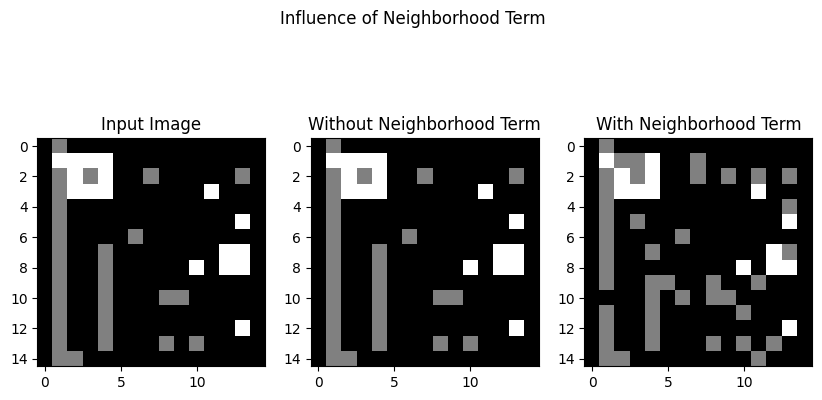

In [ ]:
# Adding the Neighborhood term increasing problem difficulty significantly. We see that with the Neighborhood distance term, the NL Solver is not able to replicate the original input at l=1.


solutions = []
for include in [False, True]:

    l = 1

    n, m = X_noisy.shape

    model = Model()

    input = model.constant(X_noisy)

    X_recon = model.integer(X_noisy.shape, lower_bound=0, upper_bound=precision)

    c_2 = model.constant(2)
    n1 = model.constant(-1)
    zero = model.constant(0)

    neighborhood_distance_const = model.constant(1-l)
    retention_const = model.constant(l)

    objective = retention_const * ((X_recon - input)**2).sum()
    # objective = retention_const * (abs(X_recon - input).sum())

    if include:
        for i in range(n):
            for j in range(m):
                for neighbor in get_neighbor(i, j, n, m, order=1):
                    objective += zero * add(
                                    X_recon[(i, j)]* X_recon[(i, j)],
                                    X_recon[neighbor]*X_recon[neighbor],
                                    n1 * c_2 * X_recon[neighbor] * X_recon[(i, j)]
                                    ) # Neighborhood Distance

    model.minimize(objective)

    sampler = LeapHybridNLSampler(token=solver_token)
    sampler.sample(model, time_limit=30)

    solution = np.zeros(X_noisy.shape)
    for i, x in enumerate(next(model.iter_decisions()).state()):
        solution[i] = x

    solutions.append(solution)

fig, axes = plt.subplots(1, 3, figsize=(10, 5))
axes[0].imshow(X_noisy, cmap='gray')
axes[0].set_title('Input Image')
axes[1].imshow(solutions[0], cmap='gray')
axes[1].set_title('Without Neighborhood Term')
axes[2].imshow(solutions[1], cmap='gray')
axes[2].set_title('With Neighborhood Term')

plt.suptitle(f'Influence of Neighborhood Term')
plt.show()

# Block Example

In this scenario, a black block is initialized on a white background before adding noise to the entire image.

Initial L2 Loss: 0.4448
L2 Loss after denoising: 0.3337
Energy: 10415.559999999594


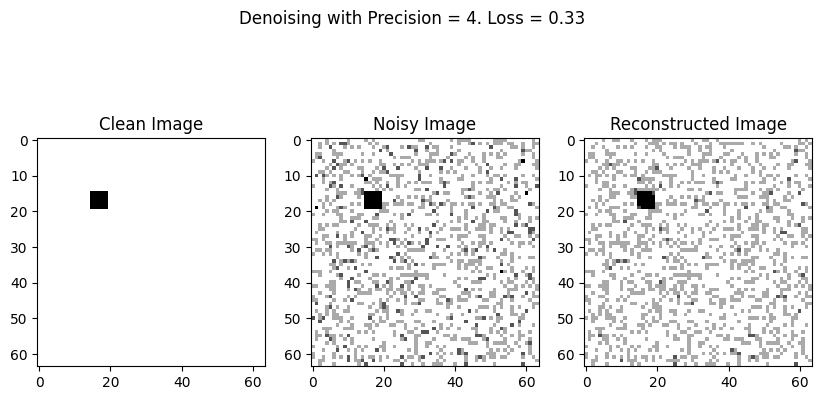

In [ ]:
#  SA 
l = 0.92 # @param {type:"slider", min:0, max:1, step:0.01}
order = 1 # @param {type:"slider", min:0, max:5, step:1}
precision = 2**2 # @param
precision -= 1


X = np.zeros((64,64))
X[:, :] = 1
X[15:20, 15:20] = 0

X_noisy = np.zeros((64,64))
X_noisy[:, :] = 1
X_noisy = X_noisy + 0.3 * np.random.normal(loc=0.0, scale=1.0, size=X.shape)
X_noisy[15:20, 15:20] = 0

X_noisy = np.clip(X_noisy, 0., 1.)

X = np.round(X * precision).astype(np.uint8)
X_noisy = np.round(X_noisy * precision).astype(np.uint8)


# X_noisy = solution

print(f'Initial L2 Loss: {get_l2_loss(X, X_noisy):.4f}')


cqm = get_cqm(X_noisy, l=l, order=order)

solution = sample_cqm(cqm, simulate=True)

print(f'L2 Loss after denoising: {get_l2_loss(X, solution):.4f}')
print(f'Energy: {get_energy(X_noisy, solution, l)}')


fig, axes = plt.subplots(1, 3, figsize=(10, 5))
axes[0].imshow(X, cmap='gray')
axes[0].set_title('Clean Image')
axes[1].imshow(X_noisy, cmap='gray')
axes[1].set_title('Noisy Image')
cax2 = axes[2].imshow(solution, cmap='gray')
axes[2].set_title('Reconstructed Image')
# plt.colorbar(cax2, ax=axes[2])
plt.suptitle(f'Denoising with Precision = {precision+1}. Loss = {get_l2_loss(X, solution):.2f}')
plt.show()


Initial L2 Loss: 0.0466
L2 Loss after denoising: 0.0310
Energy: 4043.919999999615


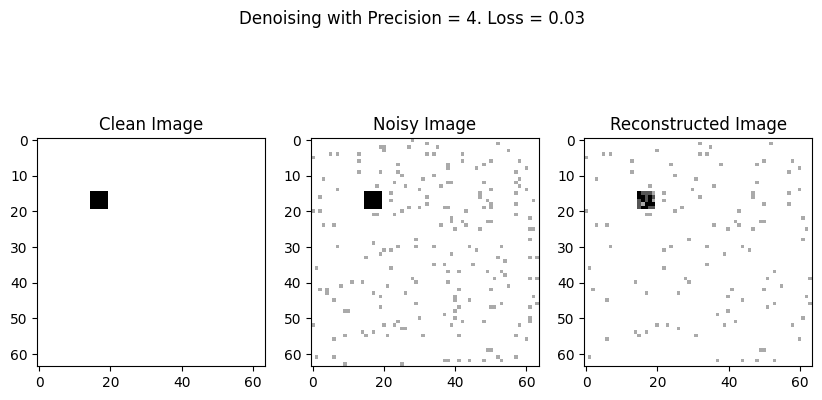

In [ ]:
#  CQM 
l = 0.92 # @param {type:"slider", min:0, max:1, step:0.01}
order = 1 # @param {type:"slider", min:0, max:5, step:1}
precision = 2**2 # @param
precision -= 1


X = np.zeros((64,64))
X[:, :] = 1
X[15:20, 15:20] = 0

X_noisy = np.zeros((64,64))
X_noisy[:, :] = 1
X_noisy = X_noisy + 0.1 * np.random.normal(loc=0.0, scale=1.0, size=X.shape)
X_noisy[15:20, 15:20] = 0

X_noisy = np.clip(X_noisy, 0., 1.)

X = np.round(X * precision).astype(np.uint8)
X_noisy = np.round(X_noisy * precision).astype(np.uint8)


# X_noisy = solution

print(f'Initial L2 Loss: {get_l2_loss(X, X_noisy):.4f}')


cqm = get_cqm(X_noisy, l=l, order=order, precision=precision)

solution = sample_cqm(cqm, simulate=False)

print(f'L2 Loss after denoising: {get_l2_loss(X, solution):.4f}')
print(f'Energy: {get_energy(X_noisy, solution, l)}')


fig, axes = plt.subplots(1, 3, figsize=(10, 5))
axes[0].imshow(X, cmap='gray')
axes[0].set_title('Clean Image')
axes[1].imshow(X_noisy, cmap='gray')
axes[1].set_title('Noisy Image')
cax2 = axes[2].imshow(solution, cmap='gray')
axes[2].set_title('Reconstructed Image')
# plt.colorbar(cax2, ax=axes[2])
plt.suptitle(f'Denoising with Precision = {precision+1}. Loss = {get_l2_loss(X, solution):.2f}')
plt.show()



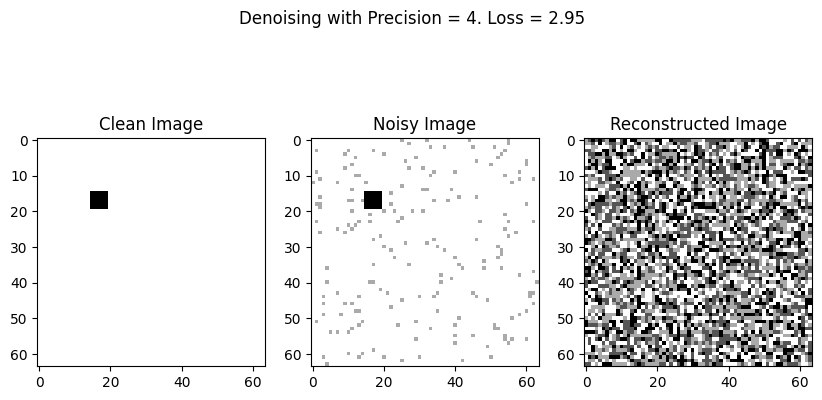

In [ ]:
#  NL 
# Alt method from Ken

l = 0.95 # @param {type:"slider", min:0, max:1, step:0.01}
order = 1 # @param {type:"slider", min:0, max:5, step:1}
precision = 2**2 # @param
precision -= 1

X = np.zeros((64,64))
X[:, :] = 1
X[15:20, 15:20] = 0

X_noisy = np.zeros((64,64))
X_noisy[:, :] = 1
X_noisy = X_noisy + 0.1 * np.random.normal(loc=0.0, scale=1.0, size=X.shape)
X_noisy[15:20, 15:20] = 0

X_noisy = np.clip(X_noisy, 0., 1.)

X = np.round(X * precision).astype(np.uint8)
X_noisy = np.round(X_noisy * precision).astype(np.uint8)


n, m = X_noisy.shape

model = Model()

input = model.constant(X_noisy)

X_recon = model.integer(X_noisy.shape, lower_bound=0, upper_bound=precision)

c_2 = model.constant(2)
n1 = model.constant(-1)
zero = model.constant(0)

neighborhood_distance_const = model.constant(1-l)
retention_const = model.constant(l)

objective = retention_const * ((X_recon - input)**2).sum()
# objective = retention_const * (abs(X_recon - input).sum())

for i in range(n):
    for j in range(m):
        for neighbor in get_neighbor(i, j, n, m, order=1):
            objective += neighborhood_distance_const * add(
                            X_recon[(i, j)]* X_recon[(i, j)],
                            X_recon[neighbor]*X_recon[neighbor],
                            n1 * c_2 * X_recon[neighbor] * X_recon[(i, j)]
                            ) # Neighborhood Distance


model.minimize(objective)

sampler = LeapHybridNLSampler(token=solver_token)
sampler.sample(model, time_limit=90)

solution = np.zeros(X_noisy.shape)
for i, x in enumerate(next(model.iter_decisions()).state()):
    solution[i] = x

fig, axes = plt.subplots(1, 3, figsize=(10, 5))
axes[0].imshow(X, cmap='gray')
axes[0].set_title('Clean Image')
axes[1].imshow(X_noisy, cmap='gray')
axes[1].set_title('Noisy Image')
cax2 = axes[2].imshow(solution, cmap='gray')
axes[2].set_title('Reconstructed Image')
# plt.colorbar(cax2, ax=axes[2])
plt.suptitle(f'Denoising with Precision = {precision+1}. Loss = {get_l2_loss(X, solution):.2f}')
plt.show()


# Image Example
Using the FashionMNIST Dataset


Initial L2 Loss:11.7832, SSI = 0.72, PSNR = 19.11
L2 Loss after denoising: 16.6849


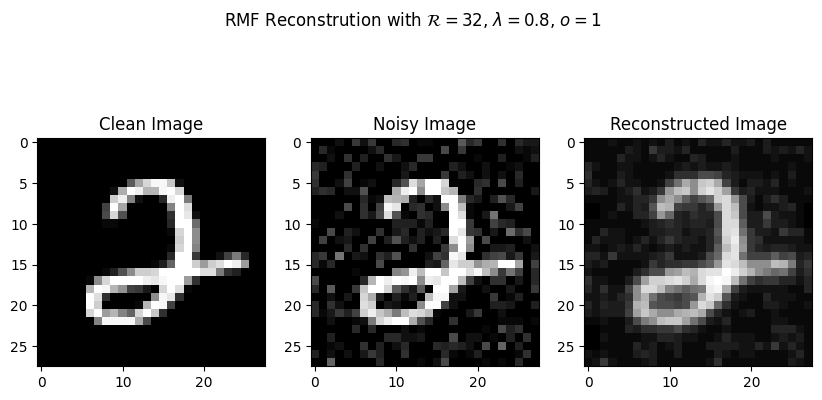

In [ ]:
idx = 16

l = 0.8
order = 1

X, X_noisy = x_train[idx], x_train_noisy[idx]
print(f'Initial L2 Loss:{get_l2_loss(X, X_noisy):.4f}, SSI = {ssi(X, X_noisy, data_range=precision+1):.2f}, PSNR = {get_psnr(X, X_noisy):.2f}')
cqm = get_cqm(X_noisy, l=l, order=1, precision=precision)

solution = sample_cqm(cqm, simulate=True)
# solution = sample_cqm(cqm, simulate=True, num_sweeps=5*precision, num_reads=50)

print(f'L2 Loss after denoising: {get_l2_loss(X, solution):.4f}')

fig, axes = plt.subplots(1, 3, figsize=(10, 5))
axes[0].imshow(X, cmap='gray')
axes[0].set_title('Clean Image')
axes[1].imshow(X_noisy, cmap='gray')
axes[1].set_title('Noisy Image')
cax2 = axes[2].imshow(solution, cmap='gray')
axes[2].set_title('Reconstructed Image')
# plt.colorbar(cax2, ax=axes[2])
plt.suptitle(r'RMF Reconstrution with $\mathcal{R} = $' + str(precision+1) + r', $\lambda = ' + str(l) + '$, $o = ' + str(order) + '$' )
            #  r' Loss = {get_l2_loss(X, solution):.2f}, SSI = {ssi(X, solution, data_range=precision+1):.2f} PSNR = {get_psnr(X, solution):.2f}')
plt.show()

save_image(X, RESULTS_DIR + f'/original_{idx}.png')
save_image(X_noisy, RESULTS_DIR + f'/noisy_{idx}.png')
save_image(solution, RESULTS_DIR + f'/denoised_sa_{idx}.png')

Initial L2 Loss:11.7832, SSI = 0.72, PSNR = 19.11
L2 Loss after denoising: 17.9719


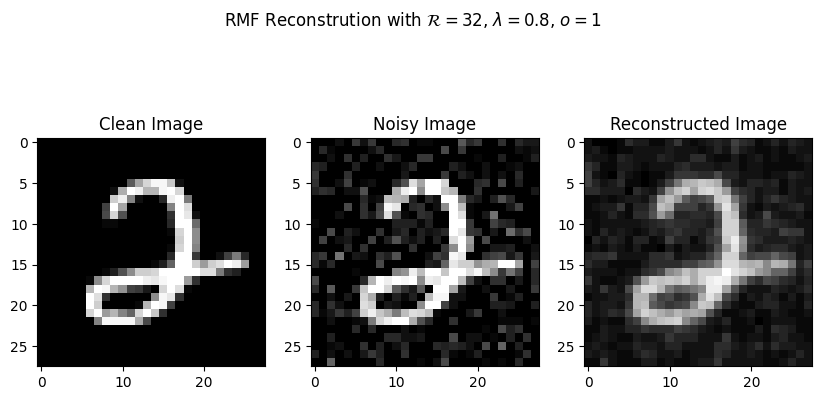

In [ ]:
idx = 16

l = 0.8
order = 1

X, X_noisy = x_train[idx], x_train_noisy[idx]
print(f'Initial L2 Loss:{get_l2_loss(X, X_noisy):.4f}, SSI = {ssi(X, X_noisy, data_range=precision+1):.2f}, PSNR = {get_psnr(X, X_noisy):.2f}')

cqm = get_cqm(X_noisy, l=l, order=1, precision=precision)

solution = sample_cqm(cqm, simulate=False)

print(f'L2 Loss after denoising: {get_l2_loss(X, solution):.4f}')

fig, axes = plt.subplots(1, 3, figsize=(10, 5))
axes[0].imshow(X, cmap='gray')
axes[0].set_title('Clean Image')
axes[1].imshow(X_noisy, cmap='gray')
axes[1].set_title('Noisy Image')
cax2 = axes[2].imshow(solution, cmap='gray')
axes[2].set_title('Reconstructed Image')
# plt.colorbar(cax2, ax=axes[2])
plt.suptitle(r'RMF Reconstrution with $\mathcal{R} = $' + str(precision+1) + r', $\lambda = ' + str(l) + '$, $o = ' + str(order) + '$' )
plt.show()

save_image(solution, RESULTS_DIR + f'/denoised_qa_{idx}.png')

## Solution Quality vs lambda




In [ ]:
def plot_with_confidence_interval(df, save_to=None):
    """
    Plots the mean total error with a shaded confidence interval for different order parameters.

    Parameters:
    - df: DataFrame containing columns 'order', 'l2_loss', 'ssi', 'psnr'
    - save_to: Optional; if provided, saves the plot to the specified path.
    """
    import matplotlib.pyplot as plt

    fig, axes = plt.subplots(1, 3, figsize=(24, 5))

    # Calculate means and confidence intervals for plotting
    grouped = df.groupby('order')
    mean_l2_loss = grouped['l2_loss'].mean()
    l2_loss_confidence = grouped['l2_loss'].sem() * 1.96  # 95% confidence interval

    mean_ssi = grouped['ssi'].mean()
    ssi_confidence = grouped['ssi'].sem() * 1.96

    mean_psnr = grouped['psnr'].mean()
    psnr_confidence = grouped['psnr'].sem() * 1.96

    order_values = df['order'].unique()

    axes[0].plot(order_values, mean_l2_loss, marker='o', label='Mean L2 Loss')
    axes[0].fill_between(order_values, mean_l2_loss - l2_loss_confidence, mean_l2_loss + l2_loss_confidence, alpha=0.2)

    axes[1].plot(order_values, mean_ssi, marker='o', label='Mean SSI')
    axes[1].fill_between(order_values, mean_ssi - ssi_confidence, mean_ssi + ssi_confidence, alpha=0.2)

    axes[2].plot(order_values, mean_psnr, marker='o', label='Mean PSNR')
    axes[2].fill_between(order_values, mean_psnr - psnr_confidence, mean_psnr + psnr_confidence, alpha=0.2)

    axes[0].set_xlabel('Order parameter')
    axes[0].set_ylabel('L2 Loss')
    axes[0].set_title('Order Parameter vs L2 Loss')
    axes[0].grid(True)
    axes[0].legend()

    axes[1].set_xlabel('Order parameter')
    axes[1].set_ylabel('SSI')
    axes[1].set_title('Order Parameter vs SSI')
    axes[1].legend()
    axes[1].grid(True)

    axes[2].set_xlabel('Order parameter')
    axes[2].set_ylabel('PSNR')
    axes[2].set_title('Order Parameter vs PSNR')
    axes[2].legend()
    axes[2].grid(True)

    if save_to is not None:
        plt.savefig(save_to)
    plt.show()

def perform_experiment_with_cqm(x_train, indices, orders=range(1, 6), l_values=[0.7, 0.8, 0.9], noise_factor=0.2, noise_fn=add_gaussian_noise, noise_fn_name='Gaussian', simulate=False):
    """
    Performs the experiment over multiple indices, varying both the `order` parameter and the `l` parameter,
    and plots the results with confidence. Saves parameters, results, and plots to a `RUNS_DIR`.

    Parameters:
    - x_train: Original images without noise
    - indices: List of indices to perform the experiment on
    - orders: List or range specifying the values of the order parameter to test (default: range(1, 6))
    - l_values: List of l values to apply (default: [0.7, 0.8, 0.9])
    - noise_factor: Noise level to apply (default: 0.2)
    """
    # Create a DataFrame to store results
    results = []

    # Create a unique directory for this run
    run_dir = RUNS_DIR + f"run_{datetime.now().strftime('%Y%m%d_%H%M')}"
    os.makedirs(run_dir, exist_ok=True)
    os.makedirs(run_dir + '/images', exist_ok=True)

    x_train_noisy = noise_fn(x_train, noise_factor=noise_factor)

    for idx_num, idx in enumerate(tqdm(indices, desc='Processing indices')):
        X, X_noisy = x_train[idx], x_train_noisy[idx]

        for order in orders:
            for l in l_values:
                # Create and solve CQM model
                cqm = get_cqm(X_noisy, l=l, order=order, precision=precision)
                solution = sample_cqm(cqm, simulate=simulate)

                # Calculate metrics
                l2_loss = get_l2_loss(X, solution)
                # ssi_value = ssi(X, solution, data_range=order)
                ssi_value = ssi(X, solution, data_range=precision)
                psnr_value = get_psnr(X, solution)

                # Append results to the DataFrame
                results.append({
                    'index': idx,
                    'order': order,
                    'l': l,
                    'l2_loss': l2_loss,
                    'ssi': ssi_value,
                    'psnr': psnr_value
                })

                # Save solution image
                image_path = os.path.join(run_dir, f'images/solution_idx_{idx}_order_{order}_l_{l:.2f}.png')
                save_image(solution, image_path)

        # print(f'Index = {idx}, Order: {order}, L: {l}, L2 Loss: {l2_loss:.4f}, SSI: {ssi_value:.4f}, PSNR: {psnr_value:.4f}')

    # Convert results to DataFrame
    results_df = pd.DataFrame(results)

    # Save parameters to a JSON file in the run directory
    params_path = os.path.join(run_dir, 'parameters.json')
    with open(params_path, 'w') as f:
        json.dump({'noise_model': noise_fn_name, 'simulate': simulate, 'orders': list(orders), 'l_values': list(l_values), 'noise_factor': noise_factor, 'indices': indices.tolist()}, f)

    # Plot using the DataFrame
    plot_with_confidence_interval(results_df, save_to=(run_dir + '/plot.png'))

    # Save the DataFrame
    with open(run_dir + f'/{noise_fn_name}_metrics_vs_order_df.pkl', 'wb') as f:
        pickle.dump(results_df, f)

    print(f'Results saved to {run_dir}')
    return results_df


Processing indices: 100%|██████████| 10/10 [06:20<00:00, 38.05s/it]


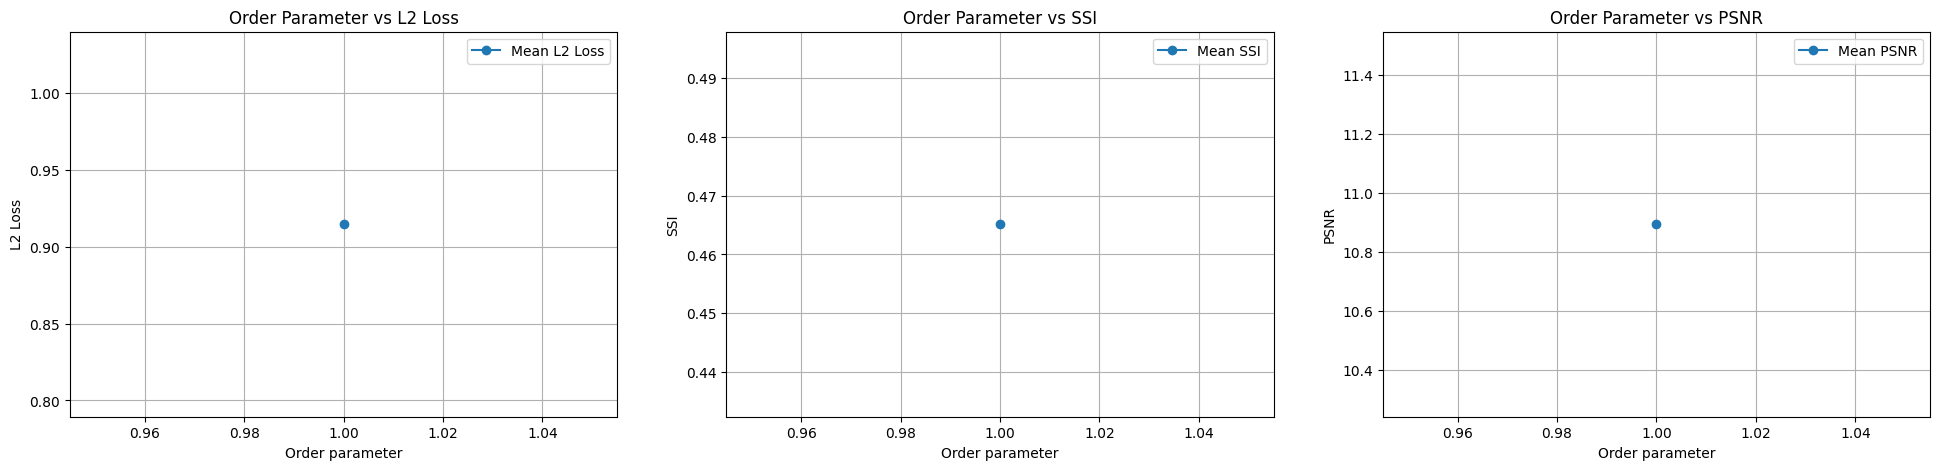

Results saved to drive/MyDrive/RMF-Discrete/runs/run_20240830_2142


In [ ]:
# Simulation
n = 10  # Number of indices to perform the experiment on
indices = np.random.choice(len(x_train), n, replace=False)

results_df = perform_experiment_with_cqm(
    reshape_data(x_train, image_shape=(32, 32)).astype(int),
    indices,
    orders=[1],
    l_values=np.linspace(0.75, 0.95, 10, endpoint=True),
    noise_factor=0.15,
    noise_fn=add_gaussian_noise,
    noise_fn_name='Gaussian',
    simulate=True
)

Processing indices: 100%|██████████| 10/10 [28:15<00:00, 169.57s/it]


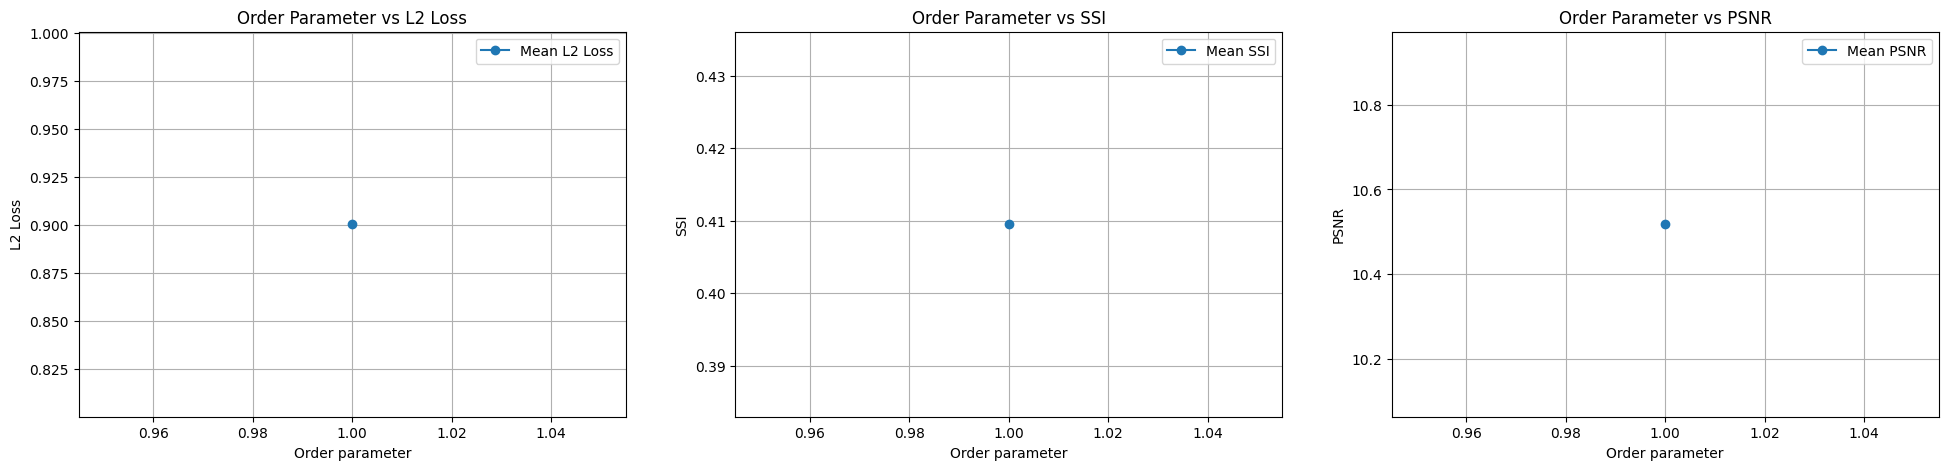

Results saved to drive/MyDrive/RMF-Discrete/runs/run_20240830_2148


In [ ]:
# CQM
n = 10  # Number of indices to perform the experiment on
indices = np.random.choice(len(x_train), n, replace=False)

results_df = perform_experiment_with_cqm(
    reshape_data(x_train, image_shape=(32, 32)).astype(int),
    indices,
    orders=[1],
    l_values=np.linspace(0.75, 0.95, 10, endpoint=True),
    noise_factor=0.15,
    noise_fn=add_gaussian_noise,
    noise_fn_name='Gaussian',
    simulate=False
)

## Explore Results

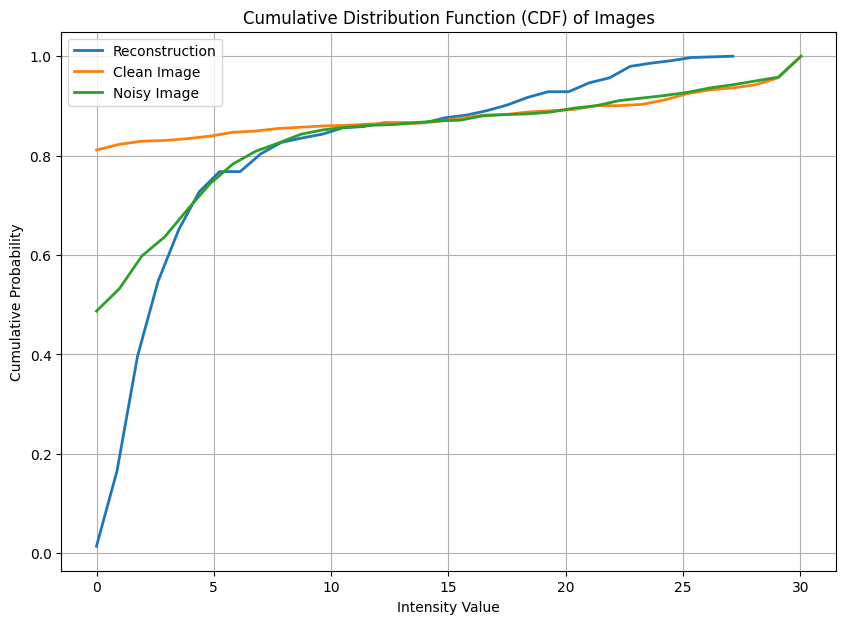

In [ ]:
# CDF Analysis
import numpy as np
import matplotlib.pyplot as plt
from skimage import color

def plot_multiple_cdfs(images, labels):
    plt.figure(figsize=(10, 7))

    for image, label in zip(images, labels):
        # Convert to grayscale if the image is RGB
        if len(image.shape) == 3:
            image = color.rgb2gray(image)

        # Flatten the image to get all pixel intensities as a 1D array
        pixel_values = image.flatten()

        # Compute the histogram and normalize it to create a probability distribution
        hist, bin_edges = np.histogram(pixel_values, bins=32, density=True)

        # Compute the CDF
        cdf = np.cumsum(hist)
        cdf = cdf / cdf[-1]  # Normalize the CDF to range from 0 to 1

        # Plot the CDF
        plt.plot(bin_edges[:-1], cdf, lw=2, label=label)

    plt.title("Cumulative Distribution Function (CDF) of Images")
    plt.xlabel("Intensity Value")
    plt.ylabel("Cumulative Probability")
    plt.legend()
    plt.grid(visible=True)
    plt.show()

# Example usage
images = [solution, X, X_noisy]  # Replace with your actual image variables
labels = ["Reconstruction", "Clean Image", "Noisy Image"]  # Labels for the images
plot_multiple_cdfs(images, labels)


### CQM

In [ ]:
# os.listdir(BASE_DIR + 'runs/Quality_vs_l_CQM/run_20240830_2148/Gaussian_metrics_vs_order_df.pkl')
df = pd.read_pickle(BASE_DIR + 'runs/Quality_vs_l_CQM/run_20240830_2148/Gaussian_metrics_vs_order_df.pkl')
df

,index,order,l,l2_loss,ssi,psnr
0,6700,1,0.750000,0.685547,0.376633,11.182054
1,6700,1,0.772222,0.585938,0.390987,11.863912
2,6700,1,0.794444,0.616211,0.378996,11.645131
3,6700,1,0.816667,0.594727,0.372402,11.799252
4,6700,1,0.838889,0.567383,0.391648,12.003663
...,...,...,...,...,...,...
95,29216,1,0.861111,1.332031,0.368535,8.297281
96,29216,1,0.883333,1.304688,0.375556,8.387360
97,29216,1,0.905556,1.321289,0.372276,8.332447
98,29216,1,0.927778,1.397461,0.352738,8.089028


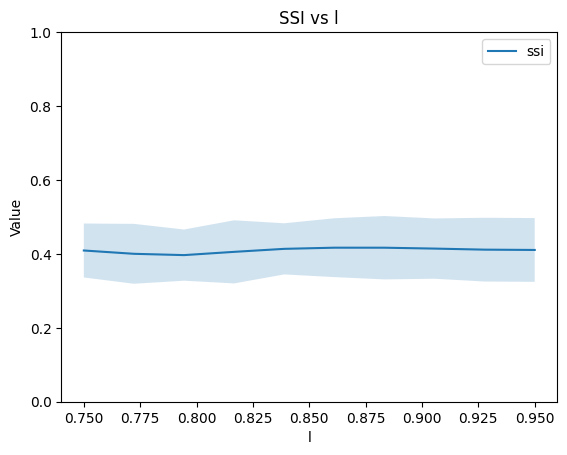

In [ ]:
# prompt: Using dataframe df: Plot l on the x axis, and plot a line of ssi and psnr with its 95% confidence interval . Use scipy and matplotlib. Set the y range to be [0, 1]

from scipy import stats

l_values = df['l'].unique()
ssi_means = []
ssi_stderr = []
for l in l_values:
  temp_df = df[df['l'] == l]
  ssi_means.append(np.mean(temp_df['ssi']))
  ssi_stderr.append(stats.sem(temp_df['ssi']))

# Plot the lines with confidence intervals
plt.plot(l_values, ssi_means, label='ssi')
plt.fill_between(l_values, np.array(ssi_means) - 1.96 * np.array(ssi_stderr), np.array(ssi_means) + 1.96 * np.array(ssi_stderr), alpha=0.2)

# Set the y range
plt.ylim([0, 1])

# Add labels and legend
plt.xlabel('l')
plt.ylabel('Value')
plt.title('SSI vs l')
plt.legend()

# Display the plot
plt.show()


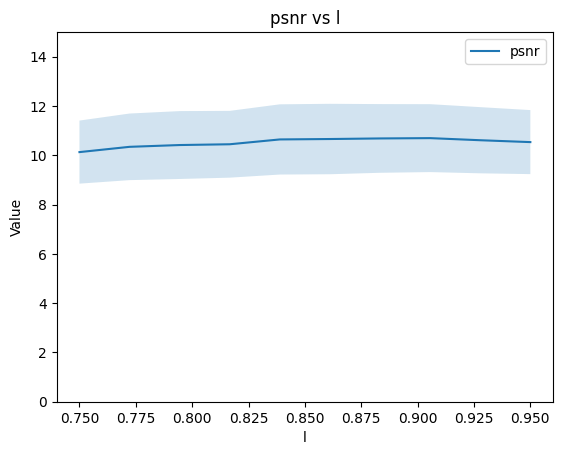

In [ ]:
# prompt: Using dataframe df: Plot l on the x axis, and plot a line of ssi and psnr with its 95% confidence interval . Use scipy and matplotlib. Set the y range to be [0, 1]

l_values = df['l'].unique()
psnr_means = []
psnr_stderr = []
for l in l_values:
  temp_df = df[df['l'] == l]
  psnr_means.append(np.mean(temp_df['psnr']))
  psnr_stderr.append(stats.sem(temp_df['psnr']))

# Plot the lines with confidence intervals
plt.plot(l_values, psnr_means, label='psnr')
plt.fill_between(l_values, np.array(psnr_means) - 1.96 * np.array(psnr_stderr), np.array(psnr_means) + 1.96 * np.array(psnr_stderr), alpha=0.2)

plt.ylim([0, 15])
plt.xlabel('l')
plt.ylabel('Value')
plt.title('psnr vs l')
plt.legend()

# Display the plot
plt.show()


### SA

In [ ]:
# os.listdir(BASE_DIR + 'runs/Quality_vs_l_SA/run_20240830_2142')
df = pd.read_pickle(BASE_DIR + 'runs/Quality_vs_l_SA/run_20240830_2142/Gaussian_metrics_vs_order_df.pkl')
df

,index,order,l,l2_loss,ssi,psnr
0,48432,1,0.750000,0.762695,0.448344,10.718914
1,48432,1,0.772222,0.762695,0.454029,10.718914
2,48432,1,0.794444,0.758789,0.460270,10.741214
3,48432,1,0.816667,0.761719,0.475284,10.724479
4,48432,1,0.838889,0.752930,0.464309,10.774881
...,...,...,...,...,...,...
95,36389,1,0.861111,1.886719,0.231740,6.785353
96,36389,1,0.883333,1.894531,0.217505,6.767407
97,36389,1,0.905556,1.855469,0.219401,6.857889
98,36389,1,0.927778,1.865234,0.220607,6.835091


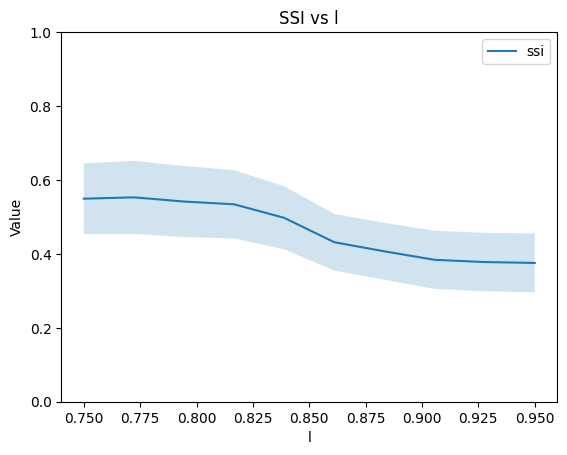

In [ ]:
l_values = df['l'].unique()
ssi_means = []
ssi_stderr = []
for l in l_values:
  temp_df = df[df['l'] == l]
  ssi_means.append(np.mean(temp_df['ssi']))
  ssi_stderr.append(stats.sem(temp_df['ssi']))

# Plot the lines with confidence intervals
plt.plot(l_values, ssi_means, label='ssi')
plt.fill_between(l_values, np.array(ssi_means) - 1.96 * np.array(ssi_stderr), np.array(ssi_means) + 1.96 * np.array(ssi_stderr), alpha=0.2)

# Set the y range
plt.ylim([0, 1])

# Add labels and legend
plt.xlabel('l')
plt.ylabel('Value')
plt.title('SSI vs l')
plt.legend()

# Display the plot
plt.show()

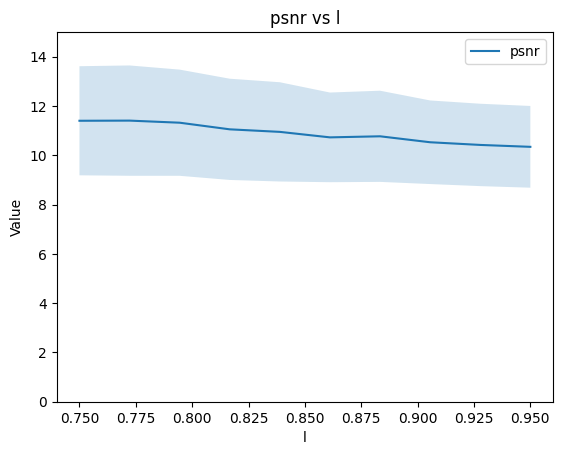

In [ ]:
l_values = df['l'].unique()
psnr_means = []
psnr_stderr = []
for l in l_values:
  temp_df = df[df['l'] == l]
  psnr_means.append(np.mean(temp_df['psnr']))
  psnr_stderr.append(stats.sem(temp_df['psnr']))

# Plot the lines with confidence intervals
plt.plot(l_values, psnr_means, label='psnr')
plt.fill_between(l_values, np.array(psnr_means) - 1.96 * np.array(psnr_stderr), np.array(psnr_means) + 1.96 * np.array(psnr_stderr), alpha=0.2)

plt.ylim([0, 15])
plt.xlabel('l')
plt.ylabel('Value')
plt.title('psnr vs l')
plt.legend()

# Display the plot
plt.show()

### Combined


In [ ]:
df_cqm = pd.read_pickle(BASE_DIR + 'runs/Quality_vs_l_CQM/run_20240830_2148/Gaussian_metrics_vs_order_df.pkl')
df_sa = pd.read_pickle(BASE_DIR + 'runs/Quality_vs_l_SA/run_20240830_2142/Gaussian_metrics_vs_order_df.pkl')

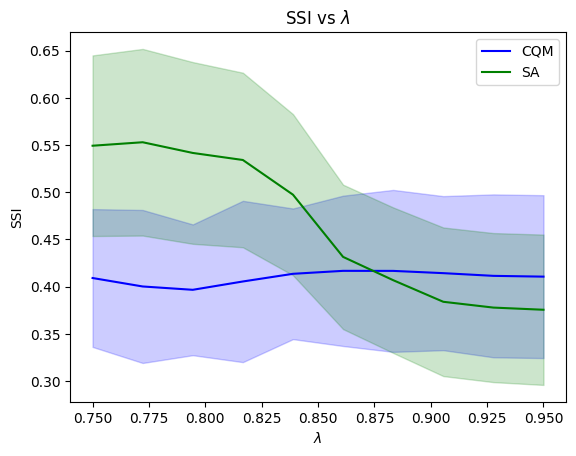

In [ ]:
l_values = df_cqm['l'].unique()

ssi_means_cqm = []
ssi_stderr_cqm = []
for l in l_values:
  temp_df = df_cqm[df_cqm['l'] == l]
  ssi_means_cqm.append(np.mean(temp_df['ssi']))
  ssi_stderr_cqm.append(stats.sem(temp_df['ssi']))

# Plot the lines with confidence intervals
plt.plot(l_values, ssi_means_cqm, 'b', label='CQM')
plt.fill_between(l_values, np.array(ssi_means_cqm) - 1.96 * np.array(ssi_stderr_cqm), np.array(ssi_means_cqm) + 1.96 * np.array(ssi_stderr_cqm), color='blue', alpha=0.2)



ssi_means_sa = []
ssi_stderr_sa = []
for l in l_values:
  temp_df = df_sa[df_sa['l'] == l]
  ssi_means_sa.append(np.mean(temp_df['ssi']))
  ssi_stderr_sa.append(stats.sem(temp_df['ssi']))

# Plot the lines with confidence intervals
plt.plot(l_values, ssi_means_sa, 'g', label='SA')
plt.fill_between(l_values, np.array(ssi_means_sa) - 1.96 * np.array(ssi_stderr_sa), np.array(ssi_means_sa) + 1.96 * np.array(ssi_stderr_sa), color='g', alpha=0.2)


plt.xlabel(r'$\lambda$')
plt.ylabel('SSI')
plt.title(r'SSI vs $\lambda$')
plt.legend()

# Display the plot
plt.show()

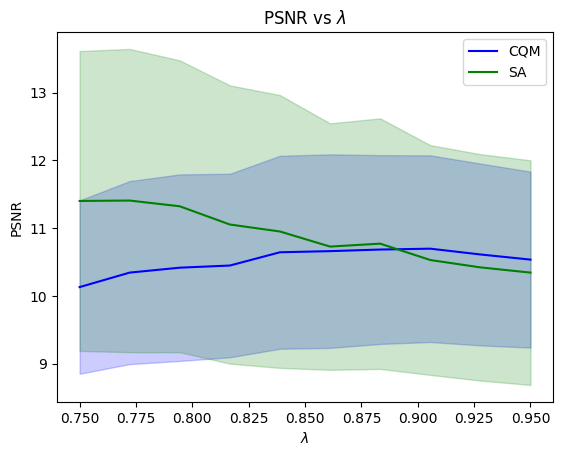

In [ ]:
psnr_means_cqm = []
psnr_stderr_cqm = []
for l in l_values:
  temp_df = df_cqm[df_cqm['l'] == l]
  psnr_means_cqm.append(np.mean(temp_df['psnr']))
  psnr_stderr_cqm.append(stats.sem(temp_df['psnr']))

# Plot the lines with confidence intervals
plt.plot(l_values, psnr_means_cqm, 'b', label='CQM')
plt.fill_between(l_values, np.array(psnr_means_cqm) - 1.96 * np.array(psnr_stderr_cqm), np.array(psnr_means_cqm) + 1.96 * np.array(psnr_stderr_cqm), color='blue', alpha=0.2)



psnr_means_sa = []
psnr_stderr_sa = []
for l in l_values:
  temp_df = df_sa[df_sa['l'] == l]
  psnr_means_sa.append(np.mean(temp_df['psnr']))
  psnr_stderr_sa.append(stats.sem(temp_df['psnr']))

# Plot the lines with confidence intervals
plt.plot(l_values, psnr_means_sa, 'g', label='SA')
plt.fill_between(l_values, np.array(psnr_means_sa) - 1.96 * np.array(psnr_stderr_sa), np.array(psnr_means_sa) + 1.96 * np.array(psnr_stderr_sa), color='g', alpha=0.2)


plt.xlabel(r'$\lambda$')
plt.ylabel('PSNR')
plt.title(r'PSNR vs $\lambda$')
plt.legend()

# Display the plot
plt.show()

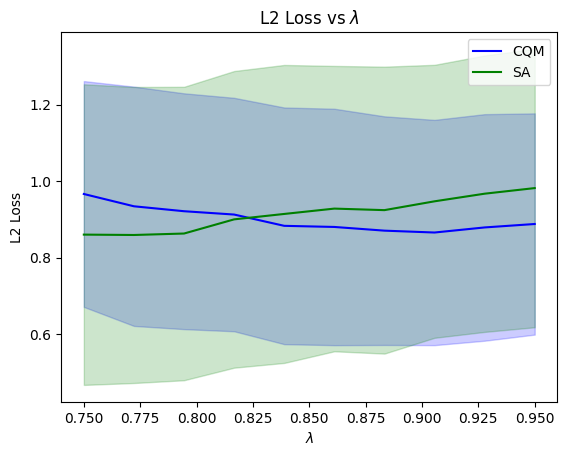

In [ ]:
l2_means_cqm = []
l2_stderr_cqm = []
for l in l_values:
  temp_df = df_cqm[df_cqm['l'] == l]
  l2_means_cqm.append(np.mean(temp_df['l2_loss']))
  l2_stderr_cqm.append(stats.sem(temp_df['l2_loss']))

# Plot the lines with confidence intervals
plt.plot(l_values, l2_means_cqm, 'b', label='CQM')
plt.fill_between(l_values, np.array(l2_means_cqm) - 1.96 * np.array(l2_stderr_cqm), np.array(l2_means_cqm) + 1.96 * np.array(l2_stderr_cqm), color='blue', alpha=0.2)



l2_means_sa = []
l2_stderr_sa = []
for l in l_values:
  temp_df = df_sa[df_sa['l'] == l]
  l2_means_sa.append(np.mean(temp_df['l2_loss']))
  l2_stderr_sa.append(stats.sem(temp_df['l2_loss']))

# Plot the lines with confidence intervals
plt.plot(l_values, l2_means_sa, 'g', label='SA')
plt.fill_between(l_values, np.array(l2_means_sa) - 1.96 * np.array(l2_stderr_sa), np.array(l2_means_sa) + 1.96 * np.array(l2_stderr_sa), color='g', alpha=0.2)


plt.xlabel(r'$\lambda$')
plt.ylabel('L2 Loss')
plt.title(r'L2 Loss vs $\lambda$')
plt.legend()

# Display the plot
plt.show()

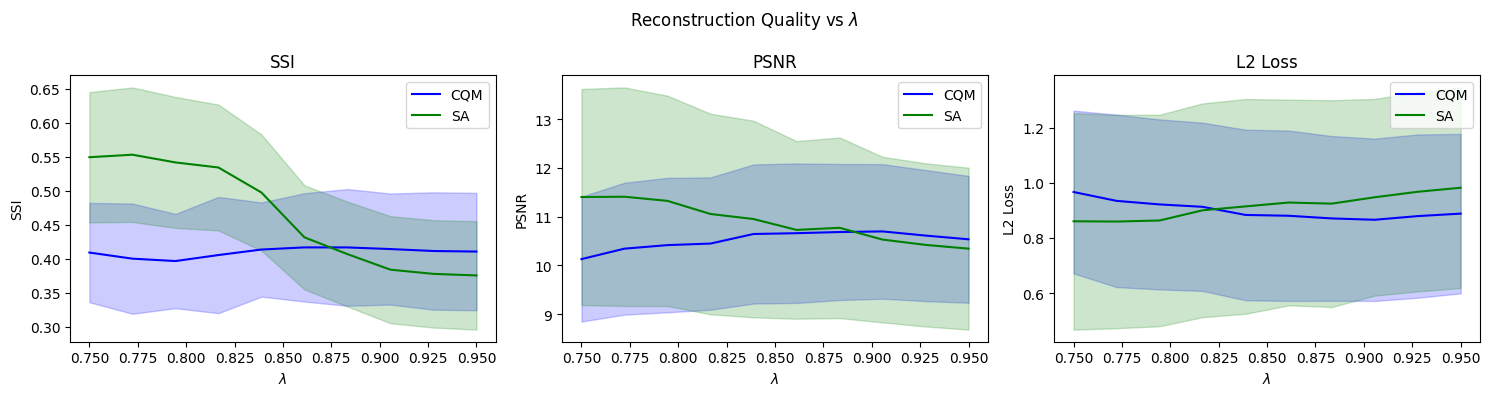

In [ ]:
# Combined Plot

l_values = df_cqm['l'].unique()

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

ssi_means_cqm = []
ssi_stderr_cqm = []
for l in l_values:
  temp_df = df_cqm[df_cqm['l'] == l]
  ssi_means_cqm.append(np.mean(temp_df['ssi']))
  ssi_stderr_cqm.append(stats.sem(temp_df['ssi']))

# Plot the lines with confidence intervals
axes[0].plot(l_values, ssi_means_cqm, 'b', label='CQM')
axes[0].fill_between(l_values, np.array(ssi_means_cqm) - 1.96 * np.array(ssi_stderr_cqm), np.array(ssi_means_cqm) + 1.96 * np.array(ssi_stderr_cqm), color='blue', alpha=0.2)



ssi_means_sa = []
ssi_stderr_sa = []
for l in l_values:
  temp_df = df_sa[df_sa['l'] == l]
  ssi_means_sa.append(np.mean(temp_df['ssi']))
  ssi_stderr_sa.append(stats.sem(temp_df['ssi']))

# Plot the lines with confidence intervals
axes[0].plot(l_values, ssi_means_sa, 'g', label='SA')
axes[0].fill_between(l_values, np.array(ssi_means_sa) - 1.96 * np.array(ssi_stderr_sa), np.array(ssi_means_sa) + 1.96 * np.array(ssi_stderr_sa), color='g', alpha=0.2)


axes[0].set_xlabel(r'$\lambda$')
axes[0].set_ylabel('SSI')
axes[0].set_title(r'SSI')
axes[0].legend()

psnr_means_cqm = []
psnr_stderr_cqm = []
for l in l_values:
  temp_df = df_cqm[df_cqm['l'] == l]
  psnr_means_cqm.append(np.mean(temp_df['psnr']))
  psnr_stderr_cqm.append(stats.sem(temp_df['psnr']))

# Plot the lines with confidence intervals
axes[1].plot(l_values, psnr_means_cqm, 'b', label='CQM')
axes[1].fill_between(l_values, np.array(psnr_means_cqm) - 1.96 * np.array(psnr_stderr_cqm), np.array(psnr_means_cqm) + 1.96 * np.array(psnr_stderr_cqm), color='blue', alpha=0.2)



psnr_means_sa = []
psnr_stderr_sa = []
for l in l_values:
  temp_df = df_sa[df_sa['l'] == l]
  psnr_means_sa.append(np.mean(temp_df['psnr']))
  psnr_stderr_sa.append(stats.sem(temp_df['psnr']))

# Plot the lines with confidence intervals
axes[1].plot(l_values, psnr_means_sa, 'g', label='SA')
axes[1].fill_between(l_values, np.array(psnr_means_sa) - 1.96 * np.array(psnr_stderr_sa), np.array(psnr_means_sa) + 1.96 * np.array(psnr_stderr_sa), color='g', alpha=0.2)


axes[1].set_xlabel(r'$\lambda$')
axes[1].set_ylabel('PSNR')
axes[1].set_title(r'PSNR')
axes[1].legend()

l2_means_cqm = []
l2_stderr_cqm = []
for l in l_values:
  temp_df = df_cqm[df_cqm['l'] == l]
  l2_means_cqm.append(np.mean(temp_df['l2_loss']))
  l2_stderr_cqm.append(stats.sem(temp_df['l2_loss']))

# Plot the lines with confidence intervals
axes[2].plot(l_values, l2_means_cqm, 'b', label='CQM')
axes[2].fill_between(l_values, np.array(l2_means_cqm) - 1.96 * np.array(l2_stderr_cqm), np.array(l2_means_cqm) + 1.96 * np.array(l2_stderr_cqm), color='blue', alpha=0.2)



l2_means_sa = []
l2_stderr_sa = []
for l in l_values:
  temp_df = df_sa[df_sa['l'] == l]
  l2_means_sa.append(np.mean(temp_df['l2_loss']))
  l2_stderr_sa.append(stats.sem(temp_df['l2_loss']))

# Plot the lines with confidence intervals
axes[2].plot(l_values, l2_means_sa, 'g', label='SA')
axes[2].fill_between(l_values, np.array(l2_means_sa) - 1.96 * np.array(l2_stderr_sa), np.array(l2_means_sa) + 1.96 * np.array(l2_stderr_sa), color='g', alpha=0.2)


axes[2].set_xlabel(r'$\lambda$')
axes[2].set_ylabel('L2 Loss')
axes[2].set_title(r'L2 Loss')
axes[2].legend()


plt.suptitle('Reconstruction Quality vs $\lambda$')
plt.tight_layout()
plt.show()

# Parrots Image
Using the same parrot image used in [Classical RMF Denoising](https://stanford.edu/class/ee367/Winter2018/yue_ee367_win18_report.pdf)

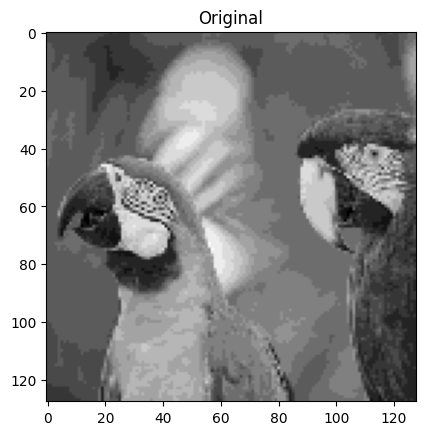

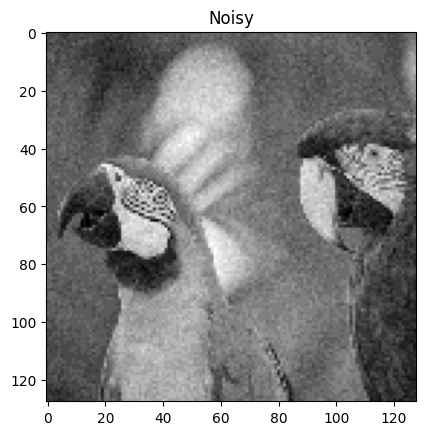

In [ ]:
image_path = '/content/drive/MyDrive/parrots.png'
noise_factor = 8 # @param
precision = 16 # @param
shape = (128, 128)

X = cv2.resize(cv2.imread(image_path, cv2.IMREAD_GRAYSCALE), shape) / 255

X_noisy = X + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X.shape) / 255
X_noisy = np.clip(X_noisy, 0., 1.)


precision -= 1
X = np.round(X * precision).astype(np.uint8)
X_noisy = np.round(X_noisy * precision).astype(np.uint8)

show_image(X, 'Original')
show_image(X_noisy, 'Noisy')



Initial L2 Loss: 0.3836
Reconstruction L2 Loss : 0.7252


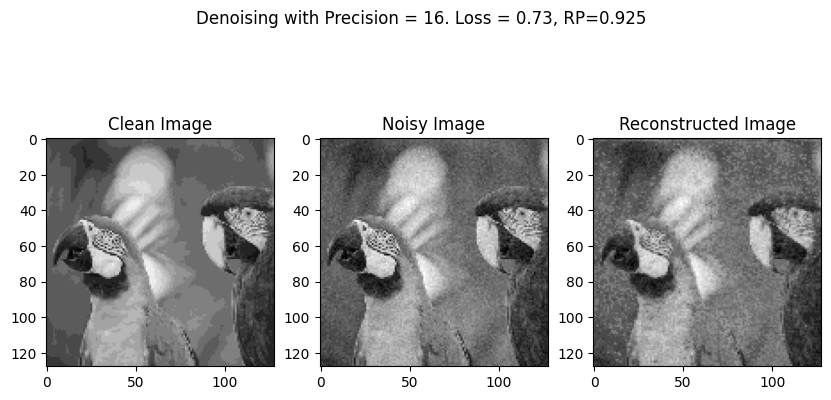

Energy: 171979.10000001057
SSI: 0.6152645286090578
PSNR: 24.917129093664308
Loss: 0.7252197265625
CPU times: user 8min 14s, sys: 1.72 s, total: 8min 15s
Wall time: 8min 24s


In [ ]:
%%time
# 6 min to simulate 128x128
l = 0.925  # @param {type:"slider", min:0, max:1, step:0.01}
order = 1 # @param {type:"slider", min:0, max:5, step:1}

print(f'Initial L2 Loss: {get_l2_loss(X, X_noisy):.4f}')
cqm = get_cqm(X_noisy, l, order, precision=precision)

solution = sample_cqm(cqm, simulate=True)

print(f'Reconstruction L2 Loss : {get_l2_loss(X, solution):.4f}')


fig, axes = plt.subplots(1, 3, figsize=(10, 5))
axes[0].imshow(X, cmap='gray')
axes[0].set_title('Clean Image')
axes[1].imshow(X_noisy, cmap='gray')
axes[1].set_title('Noisy Image')
cax2 = axes[2].imshow(solution, cmap='gray')
axes[2].set_title('Reconstructed Image')
plt.suptitle(f'Denoising with Precision = {precision+1}. Loss = {get_l2_loss(X, solution):.2f}, RP={l}')
r'Denoising with $\mathcal{R} = $' + str(precision+1) + r', $\lambda = ' + str(l) + '$, $o = ' + str(order) + '$'
plt.show()

print(f'Energy: {get_energy(X_noisy, solution, l)}')
print(f'SSI: {ssi(X, solution, data_range=precision+1)}')
print(f'PSNR: {get_psnr(X, solution)}')
print(f'Loss: {get_l2_loss(X, solution)}')
save_image(X, RESULTS_DIR + f'/original_parrot_{shape}_l={l}_o={order}.png')
save_image(X_noisy, RESULTS_DIR + f'/noisy_parrot_{shape}_l={l}_o={order}.png')
save_image(solution, RESULTS_DIR + f'/denoised_sa_parrot_{shape}_l={l}_o={order}.png')

Initial L2 Loss: 0.3836
Reconstruction L2 Loss : 2.9288


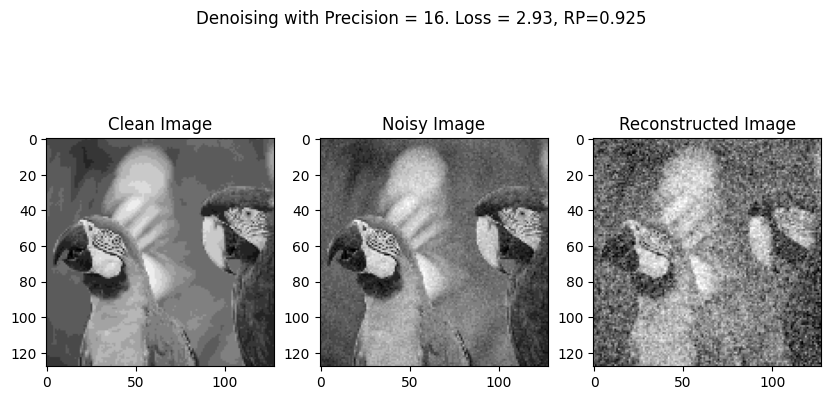

Energy: 447842.5249999911
CPU times: user 34.7 s, sys: 523 ms, total: 35.2 s
Wall time: 1min 32s


In [ ]:
%%time
l = 0.925

print(f'Initial L2 Loss: {get_l2_loss(X, X_noisy):.4f}')

cqm = get_cqm(X_noisy, l=l, order=1, precision=precision)

solution = sample_cqm(cqm, simulate=False)

print(f'Reconstruction L2 Loss : {get_l2_loss(X, solution):.4f}')

fig, axes = plt.subplots(1, 3, figsize=(10, 5))
axes[0].imshow(X, cmap='gray')
axes[0].set_title('Clean Image')
axes[1].imshow(X_noisy, cmap='gray')
axes[1].set_title('Noisy Image')
cax2 = axes[2].imshow(solution, cmap='gray')
axes[2].set_title('Reconstructed Image')
# plt.colorbar(cax2, ax=axes[2])
plt.suptitle(f'Denoising with Precision = {precision+1}. Loss = {get_l2_loss(X, solution):.2f}, RP={l}')
plt.show()
print(f'Energy: {get_energy(X_noisy, solution, l)}')

save_image(solution, RESULTS_DIR + f'/denoised_qa_parrot_{shape}_l={l}_o={order}.png')

Initial L2 Loss: 0.0801
Reconstruction L2 Loss : 0.2852


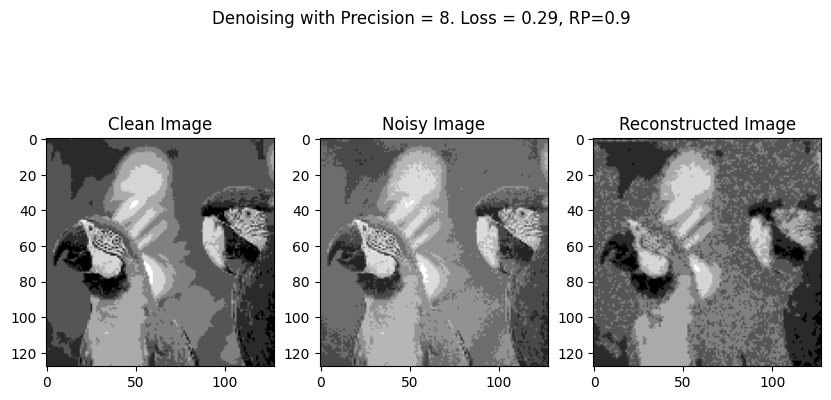

Energy: 47335.300000002775
CPU times: user 6min 35s, sys: 1.37 s, total: 6min 36s
Wall time: 6min 41s


In [ ]:
%%time
l = 0.9

print(f'Initial L2 Loss: {get_l2_loss(X, X_noisy):.4f}')

cqm = get_cqm(X_noisy, l=l, order=2, precision=precision)

solution = sample_cqm(cqm, simulate=True)


print(f'Reconstruction L2 Loss : {get_l2_loss(X, solution):.4f}')


fig, axes = plt.subplots(1, 3, figsize=(10, 5))
axes[0].imshow(X, cmap='gray')
axes[0].set_title('Clean Image')
axes[1].imshow(X_noisy, cmap='gray')
axes[1].set_title('Noisy Image')
cax2 = axes[2].imshow(solution, cmap='gray')
axes[2].set_title('Reconstructed Image')
# plt.colorbar(cax2, ax=axes[2])
plt.suptitle(f'Denoising with Precision = {precision+1}. Loss = {get_l2_loss(X, solution):.2f}, RP={l}')
plt.show()


print(f'Energy: {get_energy(X_noisy, solution, l)}')

Initial L2 Loss: 0.0801
Reconstruction L2 Loss : 2.9224


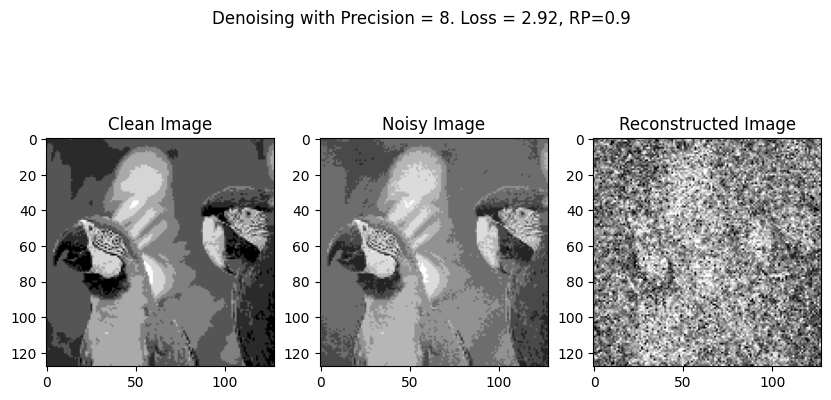

Energy: 330652.899999997
CPU times: user 52.2 s, sys: 501 ms, total: 52.7 s
Wall time: 4min


In [ ]:
%%time
# Quantum
l = 0.9

print(f'Initial L2 Loss: {get_l2_loss(X, X_noisy):.4f}')

cqm = get_cqm(X_noisy, l=l, order=2, precision=precision)

solution = sample_cqm(cqm, simulate=False)


print(f'Reconstruction L2 Loss : {get_l2_loss(X, solution):.4f}')


fig, axes = plt.subplots(1, 3, figsize=(10, 5))
axes[0].imshow(X, cmap='gray')
axes[0].set_title('Clean Image')
axes[1].imshow(X_noisy, cmap='gray')
axes[1].set_title('Noisy Image')
cax2 = axes[2].imshow(solution, cmap='gray')
axes[2].set_title('Reconstructed Image')
# plt.colorbar(cax2, ax=axes[2])
plt.suptitle(f'Denoising with Precision = {precision+1}. Loss = {get_l2_loss(X, solution):.2f}, RP={l}')
plt.show()

print(f'Energy: {get_energy(X_noisy, solution, l)}')

# Precision


In [ ]:
precision_sa = pd.read_csv(RESULTS_DIR + 'Precision_SA_Parrot.csv')
precision_cqm = pd.read_csv(RESULTS_DIR + 'Precision_CQM_Parrot.csv')
precision_sa

,Precision,SSI,PSNR,Loss
0,2,0.6804,12.3944,0.05761
1,4,0.6325,21.9100,0.31510
2,8,0.6309,21.8330,0.32120
3,16,0.7225,24.0560,0.77020
4,32,0.7873,25.6590,2.44500


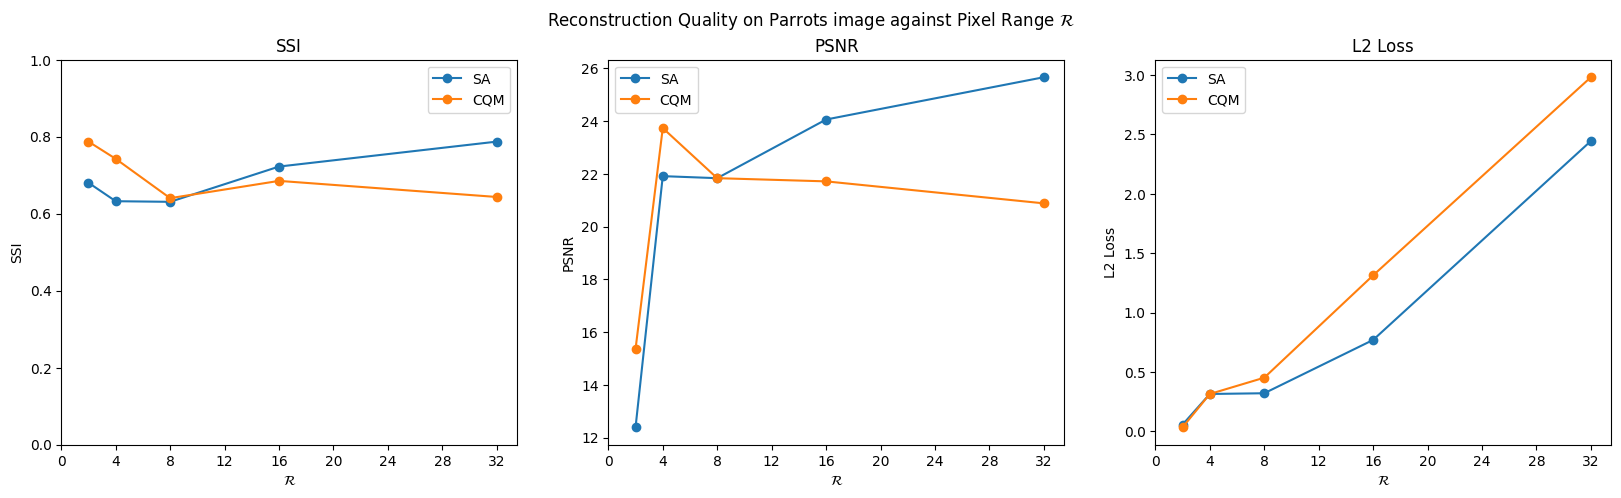

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(20, 5))

axes[0].plot(precision_sa['Precision'], precision_sa['SSI'], 'o-', label='SA')
axes[0].plot(precision_cqm['Precision'], precision_cqm['SSI'], 'o-', label='CQM')
axes[0].set_xlabel('$\mathcal{R}$')
axes[0].set_ylabel('SSI')
axes[0].set_title('SSI')
axes[0].set_ylim([0, 1])
axes[0].set_xticks(np.arange(0, 33, 4))
axes[0].legend()

axes[1].plot(precision_sa['Precision'], precision_sa['PSNR'], 'o-', label='SA')
axes[1].plot(precision_cqm['Precision'], precision_cqm['PSNR'], 'o-', label='CQM')
axes[1].set_xlabel('$\mathcal{R}$')
axes[1].set_ylabel('PSNR')
axes[1].set_title('PSNR')
axes[1].set_xticks(np.arange(0, 33, 4))
axes[1].legend()

axes[2].plot(precision_sa['Precision'], precision_sa['Loss'], 'o-', label='SA')
axes[2].plot(precision_cqm['Precision'], precision_cqm['Loss'], 'o-', label='CQM')
axes[2].set_xlabel('$\mathcal{R}$')
axes[2].set_ylabel('L2 Loss')
axes[2].set_title('L2 Loss')
axes[2].legend()
axes[2].set_xticks(np.arange(0, 33, 4))

plt.suptitle('Reconstruction Quality on Parrots image against Pixel Range $\mathcal{R}$')
plt.show()

# Higher order neighborhood.

Experiment with using `order > 1`.   

`order` includes neighboring pixel as shown below:

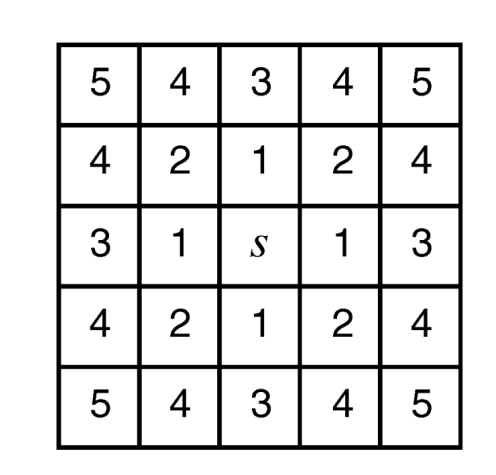


Initial L2 Loss: 0.2653
CPU times: user 2.04 s, sys: 0 ns, total: 2.04 s
Wall time: 13.7 s
L2 Loss after denoising: 0.2602


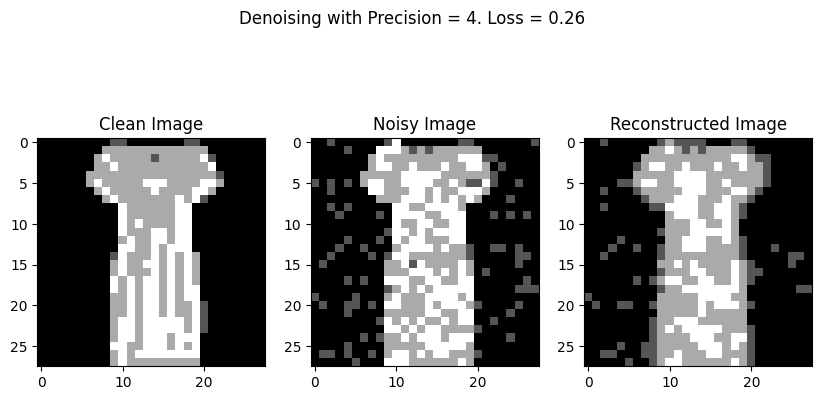

Energy: 1398.8


In [ ]:
#  Example 
l = 0.85 # @param {type:"slider", min:0, max:1, step:0.01}
order = 1 # @param {type:"slider", min:1, max:5, step:1}

idx = 20
X, X_noisy = x_train[idx], x_train_noisy[idx]
print(f'Initial L2 Loss: {get_l2_loss(X, X_noisy):.4f}')

cqm = get_cqm(X_noisy, l=l, order=order, precision=precision)

simulate = False
%time solution = sample_cqm(cqm, simulate)


print(f'L2 Loss after denoising: {get_l2_loss(X, solution):.4f}')


fig, axes = plt.subplots(1, 3, figsize=(10, 5))
axes[0].imshow(X, cmap='gray')
axes[0].set_title('Clean Image')
axes[1].imshow(X_noisy, cmap='gray')
axes[1].set_title('Noisy Image')
cax2 = axes[2].imshow(solution, cmap='gray')
axes[2].set_title('Reconstructed Image')
# plt.colorbar(cax2, ax=axes[2])
plt.suptitle(f'Denoising with Precision = {precision+1}. Loss = {get_l2_loss(X, solution):.2f}')
plt.show()
print(f'Energy: {get_energy(X_noisy, solution, l):.1f}')


## Solution Quality vs Order

Processing indices: 100%|██████████| 10/10 [44:40<00:00, 268.08s/it]


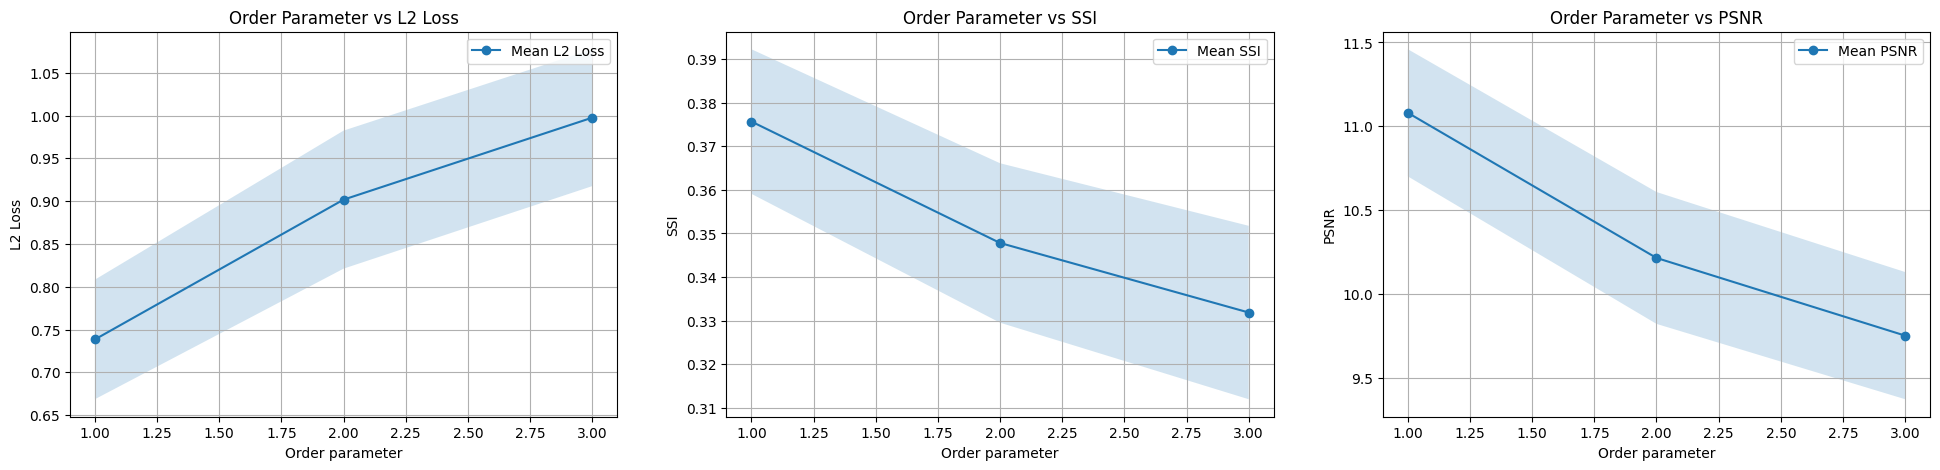

Results saved to drive/MyDrive/RMF-Discrete/runs/run_20240830_2040


In [ ]:
# 
def plot_with_confidence_interval(df, save_to=None):
    """
    Plots the mean total error with a shaded confidence interval for different order parameters.

    Parameters:
    - df: DataFrame containing columns 'order', 'l2_loss', 'ssi', 'psnr'
    - save_to: Optional; if provided, saves the plot to the specified path.
    """
    import matplotlib.pyplot as plt

    fig, axes = plt.subplots(1, 3, figsize=(24, 5))

    # Calculate means and confidence intervals for plotting
    grouped = df.groupby('order')
    mean_l2_loss = grouped['l2_loss'].mean()
    l2_loss_confidence = grouped['l2_loss'].sem() * 1.96  # 95% confidence interval

    mean_ssi = grouped['ssi'].mean()
    ssi_confidence = grouped['ssi'].sem() * 1.96

    mean_psnr = grouped['psnr'].mean()
    psnr_confidence = grouped['psnr'].sem() * 1.96

    order_values = df['order'].unique()

    axes[0].plot(order_values, mean_l2_loss, marker='o', label='Mean L2 Loss')
    axes[0].fill_between(order_values, mean_l2_loss - l2_loss_confidence, mean_l2_loss + l2_loss_confidence, alpha=0.2)

    axes[1].plot(order_values, mean_ssi, marker='o', label='Mean SSI')
    axes[1].fill_between(order_values, mean_ssi - ssi_confidence, mean_ssi + ssi_confidence, alpha=0.2)

    axes[2].plot(order_values, mean_psnr, marker='o', label='Mean PSNR')
    axes[2].fill_between(order_values, mean_psnr - psnr_confidence, mean_psnr + psnr_confidence, alpha=0.2)

    axes[0].set_xlabel('Order parameter')
    axes[0].set_ylabel('L2 Loss')
    axes[0].set_title('Order Parameter vs L2 Loss')
    axes[0].grid(True)
    axes[0].legend()

    axes[1].set_xlabel('Order parameter')
    axes[1].set_ylabel('SSI')
    axes[1].set_title('Order Parameter vs SSI')
    axes[1].legend()
    axes[1].grid(True)

    axes[2].set_xlabel('Order parameter')
    axes[2].set_ylabel('PSNR')
    axes[2].set_title('Order Parameter vs PSNR')
    axes[2].legend()
    axes[2].grid(True)

    if save_to is not None:
        plt.savefig(save_to)
    plt.show()

def perform_experiment_with_cqm(x_train, indices, orders=range(1, 6), l_values=[0.7, 0.8, 0.9], noise_factor=0.2, noise_fn=add_gaussian_noise, noise_fn_name='Gaussian', simulate=False):
    """
    Performs the experiment over multiple indices, varying both the `order` parameter and the `l` parameter,
    and plots the results with confidence. Saves parameters, results, and plots to a `RUNS_DIR`.

    Parameters:
    - x_train: Original images without noise
    - indices: List of indices to perform the experiment on
    - orders: List or range specifying the values of the order parameter to test (default: range(1, 6))
    - l_values: List of l values to apply (default: [0.7, 0.8, 0.9])
    - noise_factor: Noise level to apply (default: 0.2)
    """
    # Create a DataFrame to store results
    results = []

    # Create a unique directory for this run
    run_dir = RUNS_DIR + f"run_{datetime.now().strftime('%Y%m%d_%H%M')}"
    os.makedirs(run_dir, exist_ok=True)
    os.makedirs(run_dir + '/images', exist_ok=True)

    x_train_noisy = noise_fn(x_train, noise_factor=noise_factor)

    for idx_num, idx in enumerate(tqdm(indices, desc='Processing indices')):
        X, X_noisy = x_train[idx], x_train_noisy[idx]

        for order in orders:
            for l in l_values:
                # Create and solve CQM model
                cqm = get_cqm(X_noisy, l=l, order=order, precision=precision)
                solution = sample_cqm(cqm, simulate=simulate)

                # Calculate metrics
                l2_loss = get_l2_loss(X, solution)
                ssi_value = ssi(X, solution, data_range=order)
                psnr_value = get_psnr(X, solution)

                # Append results to the DataFrame
                results.append({
                    'index': idx,
                    'order': order,
                    'l': l,
                    'l2_loss': l2_loss,
                    'ssi': ssi_value,
                    'psnr': psnr_value
                })

                # Save solution image
                image_path = os.path.join(run_dir, f'images/solution_idx_{idx}_order_{order}_l_{l:.2f}.png')
                save_image(solution, image_path)

        # print(f'Index = {idx}, Order: {order}, L: {l}, L2 Loss: {l2_loss:.4f}, SSI: {ssi_value:.4f}, PSNR: {psnr_value:.4f}')

    # Convert results to DataFrame
    results_df = pd.DataFrame(results)

    # Save parameters to a JSON file in the run directory
    params_path = os.path.join(run_dir, 'parameters.json')
    with open(params_path, 'w') as f:
        json.dump({'noise_model': noise_fn_name, 'simulate': simulate, 'orders': list(orders), 'l_values': list(l_values), 'noise_factor': noise_factor, 'indices': indices.tolist()}, f)

    # Plot using the DataFrame
    plot_with_confidence_interval(results_df, save_to=(run_dir + '/plot.png'))

    # Save the DataFrame
    with open(run_dir + f'/{noise_fn_name}_metrics_vs_order_df.pkl', 'wb') as f:
        pickle.dump(results_df, f)

    print(f'Results saved to {run_dir}')
    return results_df


n = 10  # Number of indices to perform the experiment on
indices = np.random.choice(len(x_train), n, replace=False)

results_df = perform_experiment_with_cqm(
    reshape_data(x_train, image_shape=(32, 32)).astype(int),
    indices,
    orders=range(1, 4),
    l_values=np.linspace(0.75, 0.95, 5, endpoint=True),
    noise_factor=0.15,
    noise_fn=add_gaussian_noise,
    noise_fn_name='Gaussian',
    simulate=False
)


Processing indices: 100%|██████████| 10/10 [14:08<00:00, 84.87s/it]


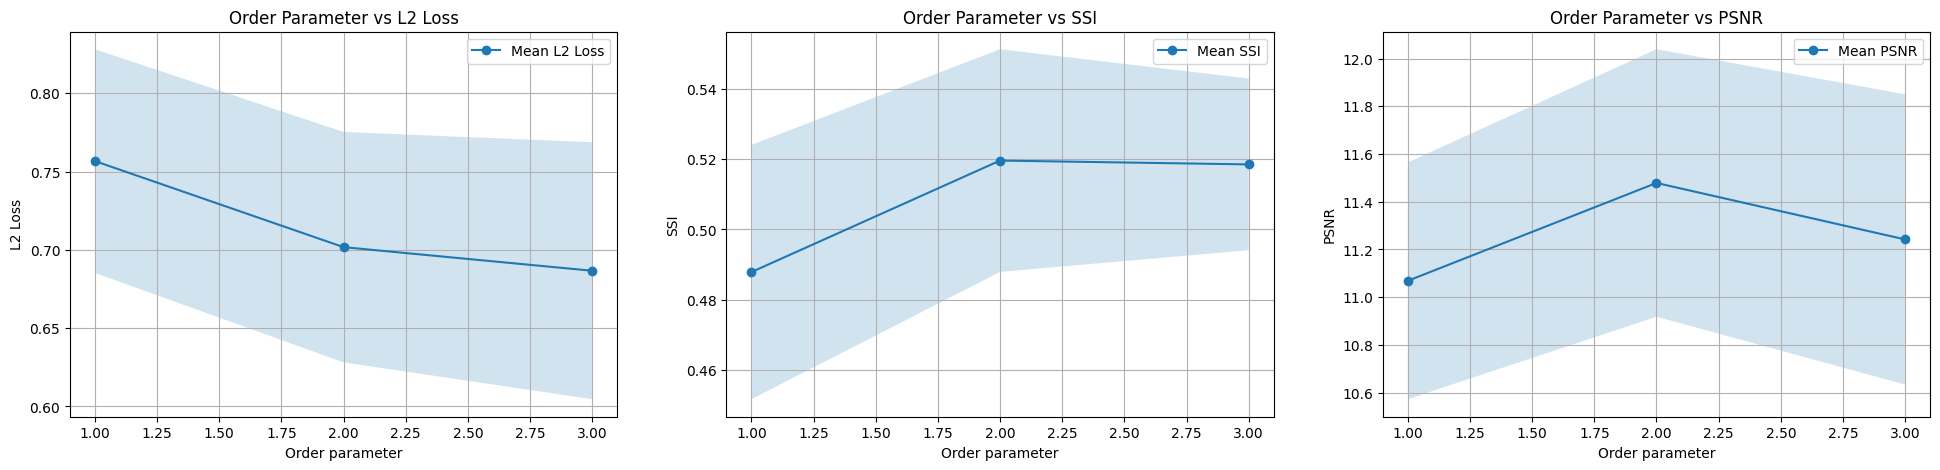

Results saved to drive/MyDrive/RMF-Discrete/runs/run_20240830_2125


In [ ]:
# Simulation
n = 10  # Number of indices to perform the experiment on
indices = np.random.choice(len(x_train), n, replace=False)

results_df = perform_experiment_with_cqm(
    reshape_data(x_train, image_shape=(32, 32)).astype(int),
    indices,
    orders=range(1, 4),
    l_values=np.linspace(0.75, 0.95, 5, endpoint=True),
    noise_factor=0.15,
    noise_fn=add_gaussian_noise,
    noise_fn_name='Gaussian',
    simulate=True
)

## Explore Results

### CQM


In [ ]:
# os.listdir(BASE_DIR + 'runs/Order_CQM/run_20240830_2040/Gaussian_metrics_vs_order_df.pkl')
df = pd.read_pickle(BASE_DIR + 'runs/Order_CQM/run_20240830_2040/Gaussian_metrics_vs_order_df.pkl')
df

,index,order,l,l2_loss,ssi,psnr
0,36059,1,0.75,0.795898,0.410819,10.533849
1,36059,1,0.80,0.605469,0.446426,11.721508
2,36059,1,0.85,0.625000,0.441362,11.583625
3,36059,1,0.90,0.630859,0.450416,11.543099
4,36059,1,0.95,0.629883,0.436316,11.549828
...,...,...,...,...,...,...
145,23391,3,0.75,0.999023,0.355218,9.546668
146,23391,3,0.80,0.974609,0.360549,9.654119
147,23391,3,0.85,1.029297,0.343032,9.417019
148,23391,3,0.90,0.853516,0.362432,10.230310


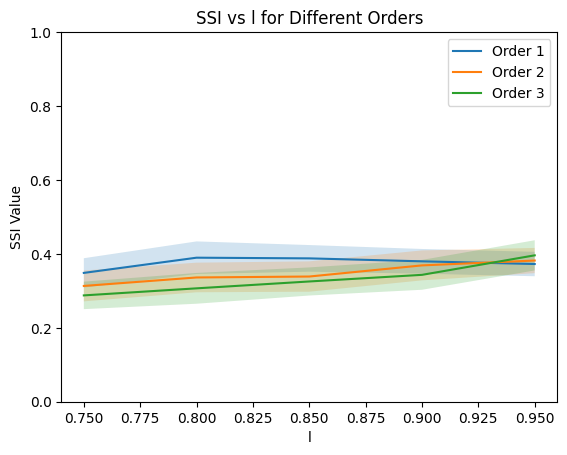

In [ ]:
order_values = df['order'].unique()

# Plot multiple lines based on 'order' groupings
for order in order_values:
    # Filter dataframe for the specific 'order'
    df_order = df[df['order'] == order]

    l_values = df_order['l'].unique()

    ssi_means = []
    ssi_stderr = []

    # Loop through unique 'l' values within the current 'order'
    for l in l_values:
        temp_df = df_order[df_order['l'] == l]
        ssi_means.append(np.mean(temp_df['ssi']))
        ssi_stderr.append(stats.sem(temp_df['ssi']))

    # Plot the line with confidence intervals for this 'order'
    plt.plot(l_values, ssi_means, label=f'Order {order}')
    plt.fill_between(l_values, np.array(ssi_means) - 1.96 * np.array(ssi_stderr),
                     np.array(ssi_means) + 1.96 * np.array(ssi_stderr), alpha=0.2)

# Set the y range
plt.ylim([0, 1])

# Add labels and legend
plt.xlabel('l')
plt.ylabel('SSI Value')
plt.title('SSI vs l for Different Orders')
plt.legend()

# Display the plot
plt.show()


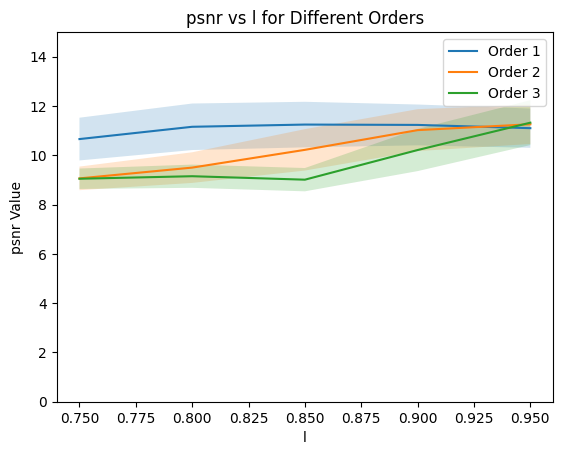

In [ ]:
# Assuming 'order' is a column in your dataframe
order_values = df['order'].unique()

# Plot multiple lines based on 'order' groupings
for order in order_values:
    # Filter dataframe for the specific 'order'
    df_order = df[df['order'] == order]

    l_values = df_order['l'].unique()

    psnr_means = []
    psnr_stderr = []

    # Loop through unique 'l' values within the current 'order'
    for l in l_values:
        temp_df = df_order[df_order['l'] == l]
        psnr_means.append(np.mean(temp_df['psnr']))
        psnr_stderr.append(stats.sem(temp_df['psnr']))

    # Plot the line with confidence intervals for this 'order'
    plt.plot(l_values, psnr_means, label=f'Order {order}')
    plt.fill_between(l_values, np.array(psnr_means) - 1.96 * np.array(psnr_stderr),
                     np.array(psnr_means) + 1.96 * np.array(psnr_stderr), alpha=0.2)

# Add labels and legend
plt.ylim([0, 15])
plt.xlabel('l')
plt.ylabel('psnr Value')
plt.title('psnr vs l for Different Orders')
plt.legend()

# Display the plot
plt.show()


### SA


In [ ]:
# os.listdir(BASE_DIR + 'runs/Order_SA/run_20240830_2125/')
df = pd.read_pickle(BASE_DIR + 'runs/Order_SA/run_20240830_2125/Gaussian_metrics_vs_order_df.pkl')

,index,order,l,l2_loss,ssi,psnr
0,11847,1,0.75,0.829102,0.426309,10.356348
1,11847,1,0.80,0.817383,0.429107,10.418170
2,11847,1,0.85,0.854492,0.421763,10.225344
3,11847,1,0.90,1.062500,0.374156,9.279136
4,11847,1,0.95,1.155273,0.346649,8.915577
...,...,...,...,...,...,...
145,34137,3,0.75,0.992188,0.510141,9.576488
146,34137,3,0.80,0.979492,0.513943,9.632415
147,34137,3,0.85,0.883789,0.547959,10.078939
148,34137,3,0.90,0.887695,0.567545,10.059786


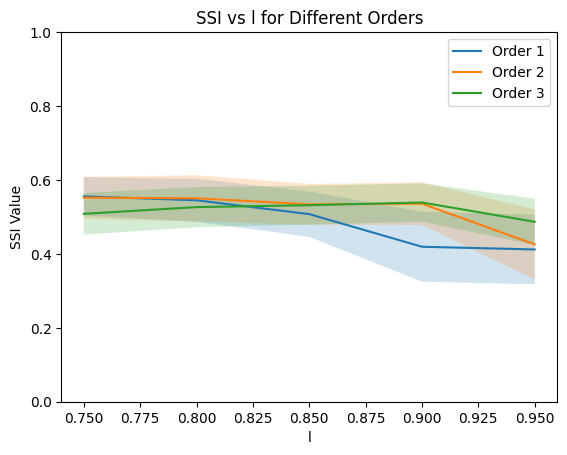

In [ ]:
# Assuming 'order' is a column in your dataframe
order_values = df['order'].unique()

# Plot multiple lines based on 'order' groupings
for order in order_values:
    # Filter dataframe for the specific 'order'
    df_order = df[df['order'] == order]

    l_values = df_order['l'].unique()

    ssi_means = []
    ssi_stderr = []

    # Loop through unique 'l' values within the current 'order'
    for l in l_values:
        temp_df = df_order[df_order['l'] == l]
        ssi_means.append(np.mean(temp_df['ssi']))
        ssi_stderr.append(stats.sem(temp_df['ssi']))

    # Plot the line with confidence intervals for this 'order'
    plt.plot(l_values, ssi_means, label=f'Order {order}')
    plt.fill_between(l_values, np.array(ssi_means) - 1.96 * np.array(ssi_stderr),
                     np.array(ssi_means) + 1.96 * np.array(ssi_stderr), alpha=0.2)

# Set the y range
plt.ylim([0, 1])

# Add labels and legend
plt.xlabel('l')
plt.ylabel('SSI Value')
plt.title('SSI vs l for Different Orders')
plt.legend()

# Display the plot
plt.show()


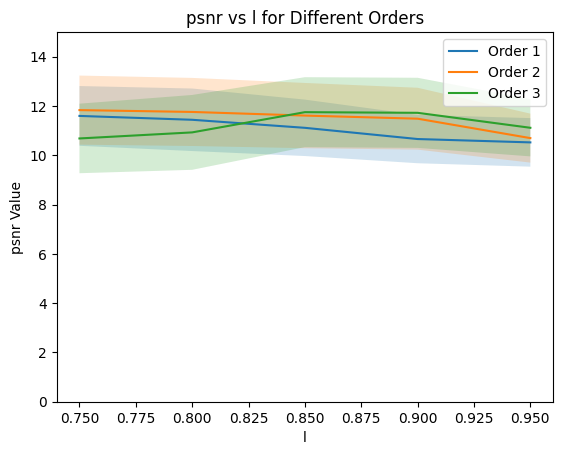

In [ ]:
# Assuming 'order' is a column in your dataframe
order_values = df['order'].unique()

# Plot multiple lines based on 'order' groupings
for order in order_values:
    # Filter dataframe for the specific 'order'
    df_order = df[df['order'] == order]

    l_values = df_order['l'].unique()

    psnr_means = []
    psnr_stderr = []

    # Loop through unique 'l' values within the current 'order'
    for l in l_values:
        temp_df = df_order[df_order['l'] == l]
        psnr_means.append(np.mean(temp_df['psnr']))
        psnr_stderr.append(stats.sem(temp_df['psnr']))

    # Plot the line with confidence intervals for this 'order'
    plt.plot(l_values, psnr_means, label=f'Order {order}')
    plt.fill_between(l_values, np.array(psnr_means) - 1.96 * np.array(psnr_stderr),
                     np.array(psnr_means) + 1.96 * np.array(psnr_stderr), alpha=0.2)

# Add labels and legend
plt.ylim([0, 15])
plt.xlabel('l')
plt.ylabel('psnr Value')
plt.title('psnr vs l for Different Orders')
plt.legend()

# Display the plot
plt.show()


### Combined


In [ ]:
df_cqm = pd.read_pickle(BASE_DIR + 'runs/Order_CQM/run_20240830_2040/Gaussian_metrics_vs_order_df.pkl')
df_sa =  pd.read_pickle(BASE_DIR + 'runs/Order_SA/run_20240830_2125/Gaussian_metrics_vs_order_df.pkl')

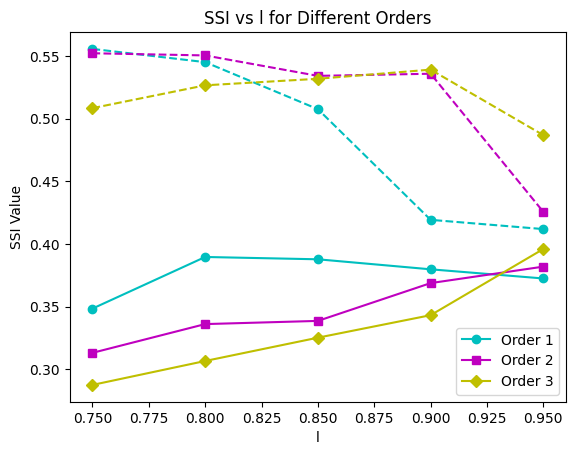

In [ ]:
order_values = df_cqm['order'].unique()
markers = ['o', 's', 'D']
colors = ['c', 'm', 'y']

# Plot multiple lines based on 'order' groupings
for order in order_values:
    # Filter dataframe for the specific 'order'
    df_order = df_cqm[df_cqm['order'] == order]

    l_values = df_order['l'].unique()

    ssi_means = []
    ssi_stderr = []

    # Loop through unique 'l' values within the current 'order'
    for l in l_values:
        temp_df = df_order[df_order['l'] == l]
        ssi_means.append(np.mean(temp_df['ssi']))
        ssi_stderr.append(stats.sem(temp_df['ssi']))

    # Plot the line with confidence intervals for this 'order'
    plt.plot(l_values, ssi_means, marker=markers[order-1], color=colors[order-1], label=f'Order {order}')
    # plt.fill_between(l_values, np.array(ssi_means) - 1.96 * np.array(ssi_stderr), np.array(ssi_means) + 1.96 * np.array(ssi_stderr), color=colors[order-1], alpha=0.1)

# Plot multiple lines based on 'order' groupings
for order in order_values:
    # Filter dataframe for the specific 'order'
    df_order = df_sa[df_sa['order'] == order]

    l_values = df_order['l'].unique()

    ssi_means = []
    ssi_stderr = []

    # Loop through unique 'l' values within the current 'order'
    for l in l_values:
        temp_df = df_order[df_order['l'] == l]
        ssi_means.append(np.mean(temp_df['ssi']))
        ssi_stderr.append(stats.sem(temp_df['ssi']))

    # Plot the line with confidence intervals for this 'order'
    plt.plot(l_values, ssi_means, marker=markers[order-1], color=colors[order-1], linestyle='--')
    # plt.fill_between(l_values, np.array(ssi_means) - 1.96 * np.array(ssi_stderr), np.array(ssi_means) + 1.96 * np.array(ssi_stderr) ,color=colors[order-1], alpha=0.1)

# plt.ylim([0, 1])

# Add labels and legend
plt.xlabel('l')
plt.ylabel('SSI Value')
plt.title('SSI vs l for Different Orders')
plt.legend()

# Display the plot
plt.show()


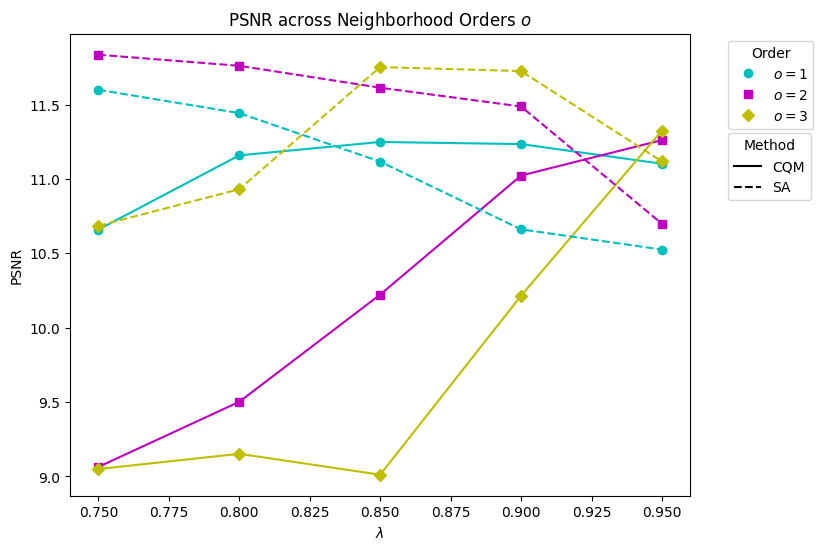

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from matplotlib.lines import Line2D

# Sample unique order values, markers, and colors
order_values = df_cqm['order'].unique()
markers = ['o', 's', 'D']
colors = ['c', 'm', 'y']

# Increase the figure size to avoid legend overlap
plt.figure(figsize=(8, 6))

# Plot CQM lines (solid) with markers and colors for each order
for order in order_values:
    df_order = df_cqm[df_cqm['order'] == order]
    l_values = df_order['l'].unique()
    ssi_means = []
    ssi_stderr = []

    for l in l_values:
        temp_df = df_order[df_order['l'] == l]
        ssi_means.append(np.mean(temp_df['psnr']))
        ssi_stderr.append(stats.sem(temp_df['psnr']))

    plt.plot(l_values, ssi_means, marker=markers[order - 1], color=colors[order - 1], linestyle='-')
    # plt.fill_between(l_values, np.array(ssi_means) - 1.96 * np.array(ssi_stderr),
    #                  np.array(ssi_means) + 1.96 * np.array(ssi_stderr), color=colors[order - 1], alpha=0.1)

# Plot SA lines (dashed) with markers and colors for each order
for order in order_values:
    df_order = df_sa[df_sa['order'] == order]
    l_values = df_order['l'].unique()
    ssi_means = []
    ssi_stderr = []

    for l in l_values:
        temp_df = df_order[df_order['l'] == l]
        ssi_means.append(np.mean(temp_df['psnr']))
        ssi_stderr.append(stats.sem(temp_df['psnr']))

    plt.plot(l_values, ssi_means, marker=markers[order - 1], color=colors[order - 1], linestyle='--')
    # plt.fill_between(l_values, np.array(ssi_means) - 1.96 * np.array(ssi_stderr),
    #                  np.array(ssi_means) + 1.96 * np.array(ssi_stderr), color=colors[order - 1], alpha=0.1)

# Custom legend entries
# Legend for Orders 1 to 3 with specific markers and colors
order_legend_elements = [
    Line2D([0], [0], color='c', marker='o', linestyle='None', label='$o = 1$'),
    Line2D([0], [0], color='m', marker='s', linestyle='None', label='$o = 2$'),
    Line2D([0], [0], color='y', marker='D', linestyle='None', label='$o = 3$')
]

# Legend for line styles representing CQM and SA
style_legend_elements = [
    Line2D([0], [0], color='black', linestyle='-', label='CQM'),
    Line2D([0], [0], color='black', linestyle='--', label='SA')
]

# Add both legends to the plot, positioning them one below the other
first_legend = plt.legend(handles=order_legend_elements, title="Order", loc='upper left', bbox_to_anchor=(1.05, 1))
plt.gca().add_artist(first_legend)  # Add the first legend manually to the plot
plt.legend(handles=style_legend_elements, title="Method", loc='upper left', bbox_to_anchor=(1.05, 0.8))

# Labels and title
plt.xlabel('$\lambda$')
plt.ylabel('PSNR')
plt.title('PSNR across Neighborhood Orders $o$')

# Display the plot
plt.show()


# Piecewise denoising

Denoising an image by splitting the image into patches, denoising them, and stitching the patches back together


In [ ]:
height, width = X_noisy.shape

n = 4  # Number of patches per row or column

# Calculate the size of each patch
patch_height = height // n
patch_width = width // n

patches = np.zeros((n, n, patch_height, patch_width))

for i in range(n):
    for j in range(n):
        patches[i, j] = X_noisy[i*patch_height:(i+1)*patch_height, j*patch_width:(j+1)*patch_width]



L2 Loss after denoising: 2.2776


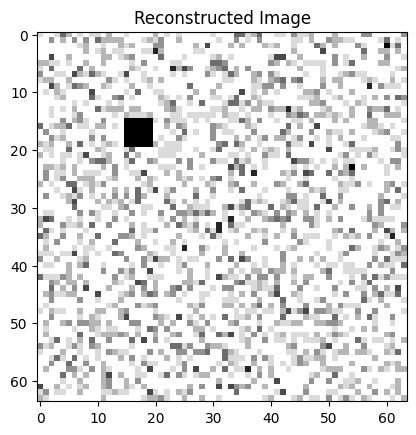

In [ ]:
l = 0.5 # @param {type:"slider", min:0, max:1, step:0.01}
order = 1 # @param {type:"slider", min:0, max:5, step:1}

X_recon = np.zeros_like(X_noisy)

for i in range(n):
    for j in range(n):
        patch = patches [i, j]

        cqm = get_cqm(X_noisy, l=l, order=order, precision=precision)

        simulate = True
        solution = sample_cqm(cqm, simulate=False)

        X_recon[i*patch_height:(i+1)*patch_height, j*patch_width:(j+1)*patch_width] = patches[i, j]

print(f'L2 Loss after denoising: {get_l2_loss(X, X_recon):.4f}')

show_image(X_recon, 'Reconstructed Image')

# Time parameter

Testing the influence of `time_limit` parameter of CQM on solution quality

Reconstruction L2 Loss : 0.4974


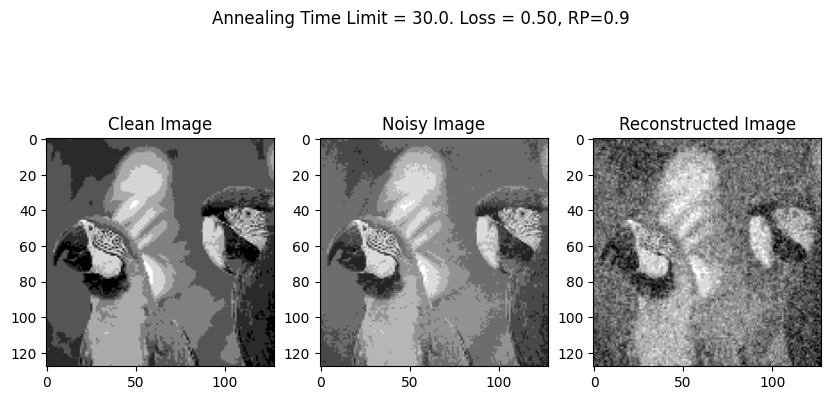

Annealing Time Limit = 30.0. Energy: -133863.70


/usr/local/lib/python3.10/dist-packages/skimage/_shared/utils.py:348: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  return func(*args, **kwargs)


Reconstruction L2 Loss : 0.5007


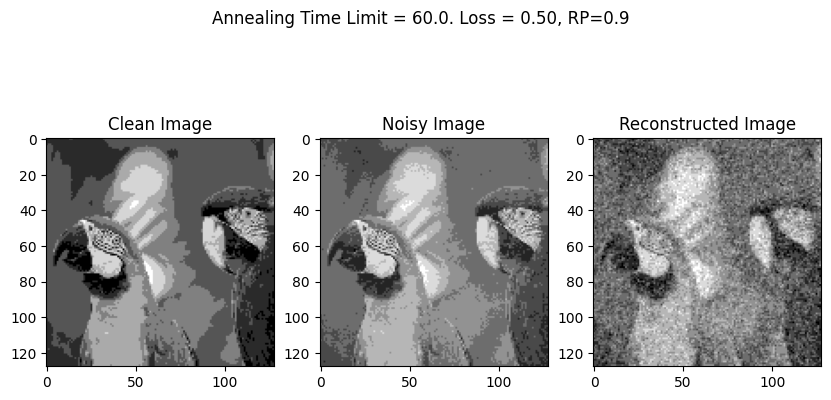

Annealing Time Limit = 60.0. Energy: -133571.90
Reconstruction L2 Loss : 0.5053


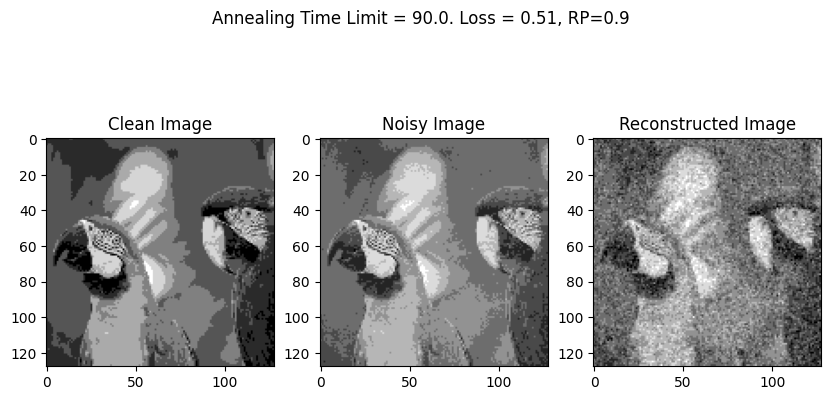

Annealing Time Limit = 90.0. Energy: -132195.90


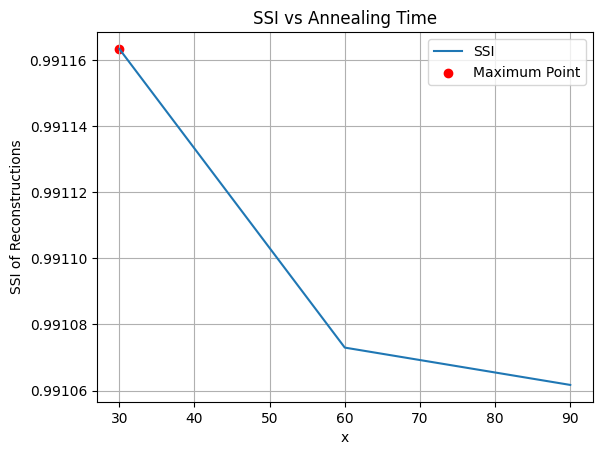

Maximum point: 30.0
Maximum value: 0.991163456749473


In [ ]:
# 
def sample_cqm_time(cqm, simulate=True, time_limit=5):
  if simulate:
    bqm, invert = cqm_to_bqm(cqm)
    sampler = SimulatedAnnealingSampler()
    sampleset = sampler.sample(bqm).aggregate()
    solution = np.array(list(invert(sampleset.first.sample).values())).reshape(X_noisy.shape)
  else:
    sampler = LeapHybridCQMSampler(token=solver_token)
    sampleset = sampler.sample_cqm(cqm, label='RMF Real', time_limit=time_limit)
    solution = np.array(list(sampleset.first[0].values())).reshape(X_noisy.shape)
  return solution

def tune_param(func, start, end, num_points):
    # Generate evenly spaced points between start and end
    x_values = np.linspace(start, end, num_points)
    y_values = [func(x) for x in x_values]  # Calculate y values for each x
    # Initialize max_value and max_point
    max_value = float('-inf')
    max_point = None
    # Iterate through each x value and find the maximum value
    for x, y in zip(x_values, y_values):
        if y > max_value:
            max_value = y
            max_point = x
    return max_point, max_value, x_values, y_values


def experiment(time_limit):
  l = 0.9


  cqm = get_cqm(X_noisy, l=l, precision=precision)

  solution = sample_cqm_time(cqm, simulate=False, time_limit=time_limit)

  print(f'Reconstruction L2 Loss : {get_l2_loss(X, solution):.4f}')

  fig, axes = plt.subplots(1, 3, figsize=(10, 5))
  axes[0].imshow(X, cmap='gray')
  axes[0].set_title('Clean Image')
  axes[1].imshow(X_noisy, cmap='gray')
  axes[1].set_title('Noisy Image')
  cax2 = axes[2].imshow(solution, cmap='gray')
  axes[2].set_title('Reconstructed Image')
  # plt.colorbar(cax2, ax=axes[2])
  plt.suptitle(f'Annealing Time Limit = {time_limit}. Loss = {get_l2_loss(X, solution):.2f}, RP={l}')
  plt.show()
  print(f'Annealing Time Limit = {time_limit}. Energy: {get_energy(X_noisy, solution, l):.2f}')

  return ssi(X, solution)


# Define the range and number of points to test
start = 30
end = 90
num_points = 3

# Find the maximum of the arbitrary function
max_point, max_value, x_values, y_values = tune_param(experiment, start, end, num_points)

# Plot the graph of checked values
plt.plot(x_values, y_values, label='SSI')
plt.scatter(max_point, max_value, color='red', label='Maximum Point')
plt.xlabel('x')
plt.ylabel('SSI of Reconstructions')
plt.title('SSI vs Annealing Time')
plt.legend()
plt.grid(True)
plt.show()

print("Maximum point:", max_point)
print("Maximum value:", max_value)


# Salt and pepper Noise

Experiment with an alternative Salt-And-Pepper Noise Model

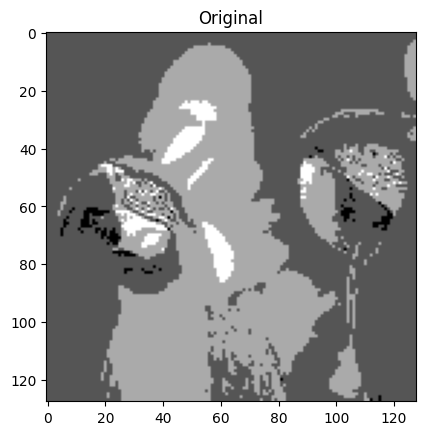

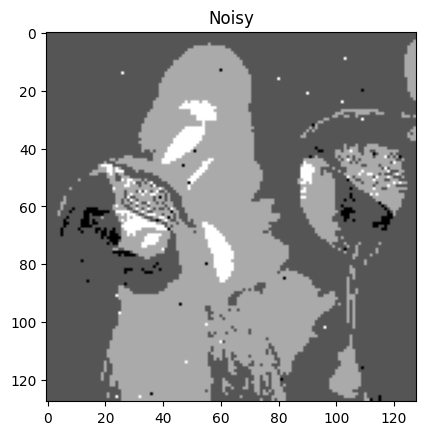

In [ ]:
def add_salt_and_pepper_noise(image, noise_level):
    """
    Add salt and pepper noise to an image.

    Parameters:
    image (numpy.ndarray): Input image.
    noise_level (float): Amount of noise to add (between 0 and 1).

    Returns:
    numpy.ndarray: Image with salt and pepper noise.
    """
    # Create a copy of the image to avoid modifying the original one
    noisy_image = np.copy(image)

    # Calculate the number of pixels to alter
    total_pixels = image.size
    num_salt = int(noise_level * total_pixels)
    num_pepper = int(noise_level * total_pixels)

    # Add salt noise (white pixels)
    for _ in range(num_salt):
        x = np.random.randint(0, image.shape[0] - 1)
        y = np.random.randint(0, image.shape[1] - 1)
        noisy_image[x, y] = 255

    # Add pepper noise (black pixels)
    for _ in range(num_pepper):
        x = np.random.randint(0, image.shape[0] - 1)
        y = np.random.randint(0, image.shape[1] - 1)
        noisy_image[x, y] = 0

    return noisy_image

image_path = 'parrots.png'
noise_factor = 0.001 # @param
precision = 4 # @param
shape = (128, 128)

X = cv2.resize(cv2.imread(image_path, cv2.IMREAD_GRAYSCALE), shape) / 255

# X_noisy = X + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X.shape) / 255
X_noisy = add_salt_and_pepper_noise(X, noise_factor)
X_noisy = np.clip(X_noisy, 0., 1.)

precision -= 1
X = np.round(X * precision).astype(np.uint8)
X_noisy = np.round(X_noisy * precision).astype(np.uint8)

show_image(X, 'Original')
show_image(X_noisy, 'Noisy')




Initial L2 Loss: 0.0056
Reconstruction L2 Loss : 0.0175


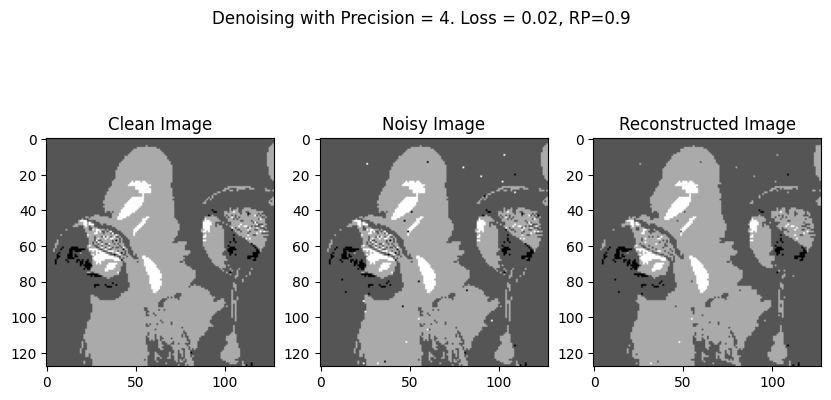

Energy: -28832.700000000874
CPU times: user 4min 38s, sys: 1.15 s, total: 4min 39s
Wall time: 4min 42s


In [ ]:
%%time
# 6 min to simulate 128x128
l = 0.9  # @param {type:"slider", min:0, max:1, step:0.01}
order = 1 # @param {type:"slider", min:0, max:5, step:1}

print(f'Initial L2 Loss: {get_l2_loss(X, X_noisy):.4f}')
cqm = get_cqm(X_noisy, l, order, precision=precision)

solution = sample_cqm(cqm, simulate=True)

print(f'Reconstruction L2 Loss : {get_l2_loss(X, solution):.4f}')


fig, axes = plt.subplots(1, 3, figsize=(10, 5))
axes[0].imshow(X, cmap='gray')
axes[0].set_title('Clean Image')
axes[1].imshow(X_noisy, cmap='gray')
axes[1].set_title('Noisy Image')
cax2 = axes[2].imshow(solution, cmap='gray')
axes[2].set_title('Reconstructed Image')
plt.suptitle(f'Denoising with Precision = {precision+1}. Loss = {get_l2_loss(X, solution):.2f}, RP={l}')
plt.show()

print(f'Energy: {get_energy(X_noisy, solution, l)}')

Initial L2 Loss: 0.0056
Reconstruction L2 Loss : 0.2745


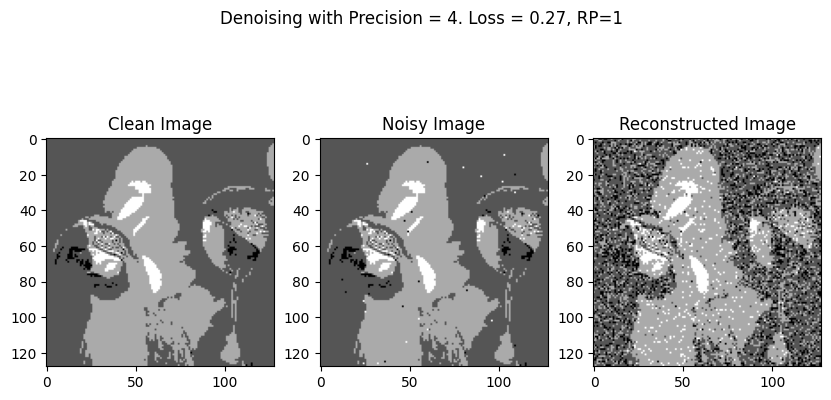

Energy: 6747.0
CPU times: user 34.2 s, sys: 301 ms, total: 34.5 s
Wall time: 44.8 s


In [ ]:
%%time
l = 1   # @param {type:"slider", min:0, max:1, step:0.01}
order = 1 # @param {type:"slider", min:0, max:5, step:1}

print(f'Initial L2 Loss: {get_l2_loss(X, X_noisy):.4f}')
cqm = get_cqm(X_noisy, l, order, precision=precision)

solution = sample_cqm(cqm, simulate=False)

print(f'Reconstruction L2 Loss : {get_l2_loss(X, solution):.4f}')


fig, axes = plt.subplots(1, 3, figsize=(10, 5))
axes[0].imshow(X, cmap='gray')
axes[0].set_title('Clean Image')
axes[1].imshow(X_noisy, cmap='gray')
axes[1].set_title('Noisy Image')
cax2 = axes[2].imshow(solution, cmap='gray')
axes[2].set_title('Reconstructed Image')
plt.suptitle(f'Denoising with Precision = {precision+1}. Loss = {get_l2_loss(X, solution):.2f}, RP={l}')
plt.show()

print(f'Energy: {get_energy(X_noisy, solution, l)}')